# Settings

In [1]:
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/data_loading.R")
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/scoring.R")
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/ensemble_methods.R")
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/ensemble_functions.R")

library(viridis)
library(tidytext)

Sys.setlocale("LC_TIME", "C")
Sys.setlocale("LC_ALL", "C")

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'MMWRweek' was built under R version 4.0.5"
Loading required package: SparseM


Attaching package: 'SparseM'


The following object is masked from 'package:base':

    backsolve


Warning message:
"package 'viridis' was built under R version 4.0.5"
Loading required package: viridisLite

Warning message:
"package 'viridisLite' was built under R version 4.0.5"
Warning message:
"package 'tidytext' was built under R version 4.0.5"


[1] "C"

[1] "C"

In [2]:
theme_set(theme_gray(base_size = 18))

In [3]:
end_date = "2021-06-19"

In [4]:
scores <- load_scores(paste0("scores/", end_date, "_scores.csv"), long_format=TRUE) %>%
  filter(!model %in% c("CU-scenario_high", "CU-scenario_mid", "CU-scenario_low", "CU-nochange", "USC-SI_kJalpha")) %>%
  filter(location != "US")

# Mean WIS

The mean WIS is computed across all states and dates. The gray area shows the baseline performance. 

In [5]:
scale_x_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_x_discrete(labels = function(x) parse(text=gsub(reg, "", x)), ...)
}

In [6]:
options(repr.plot.width=15, repr.plot.height=28, repr.plot.res = 300)

In [7]:
base_df <- subset(scores, model=="COVIDhub-baseline" & score == "wis")  %>% 
  group_by(target)  %>% 
  summarize(mean_wis = mean(value))

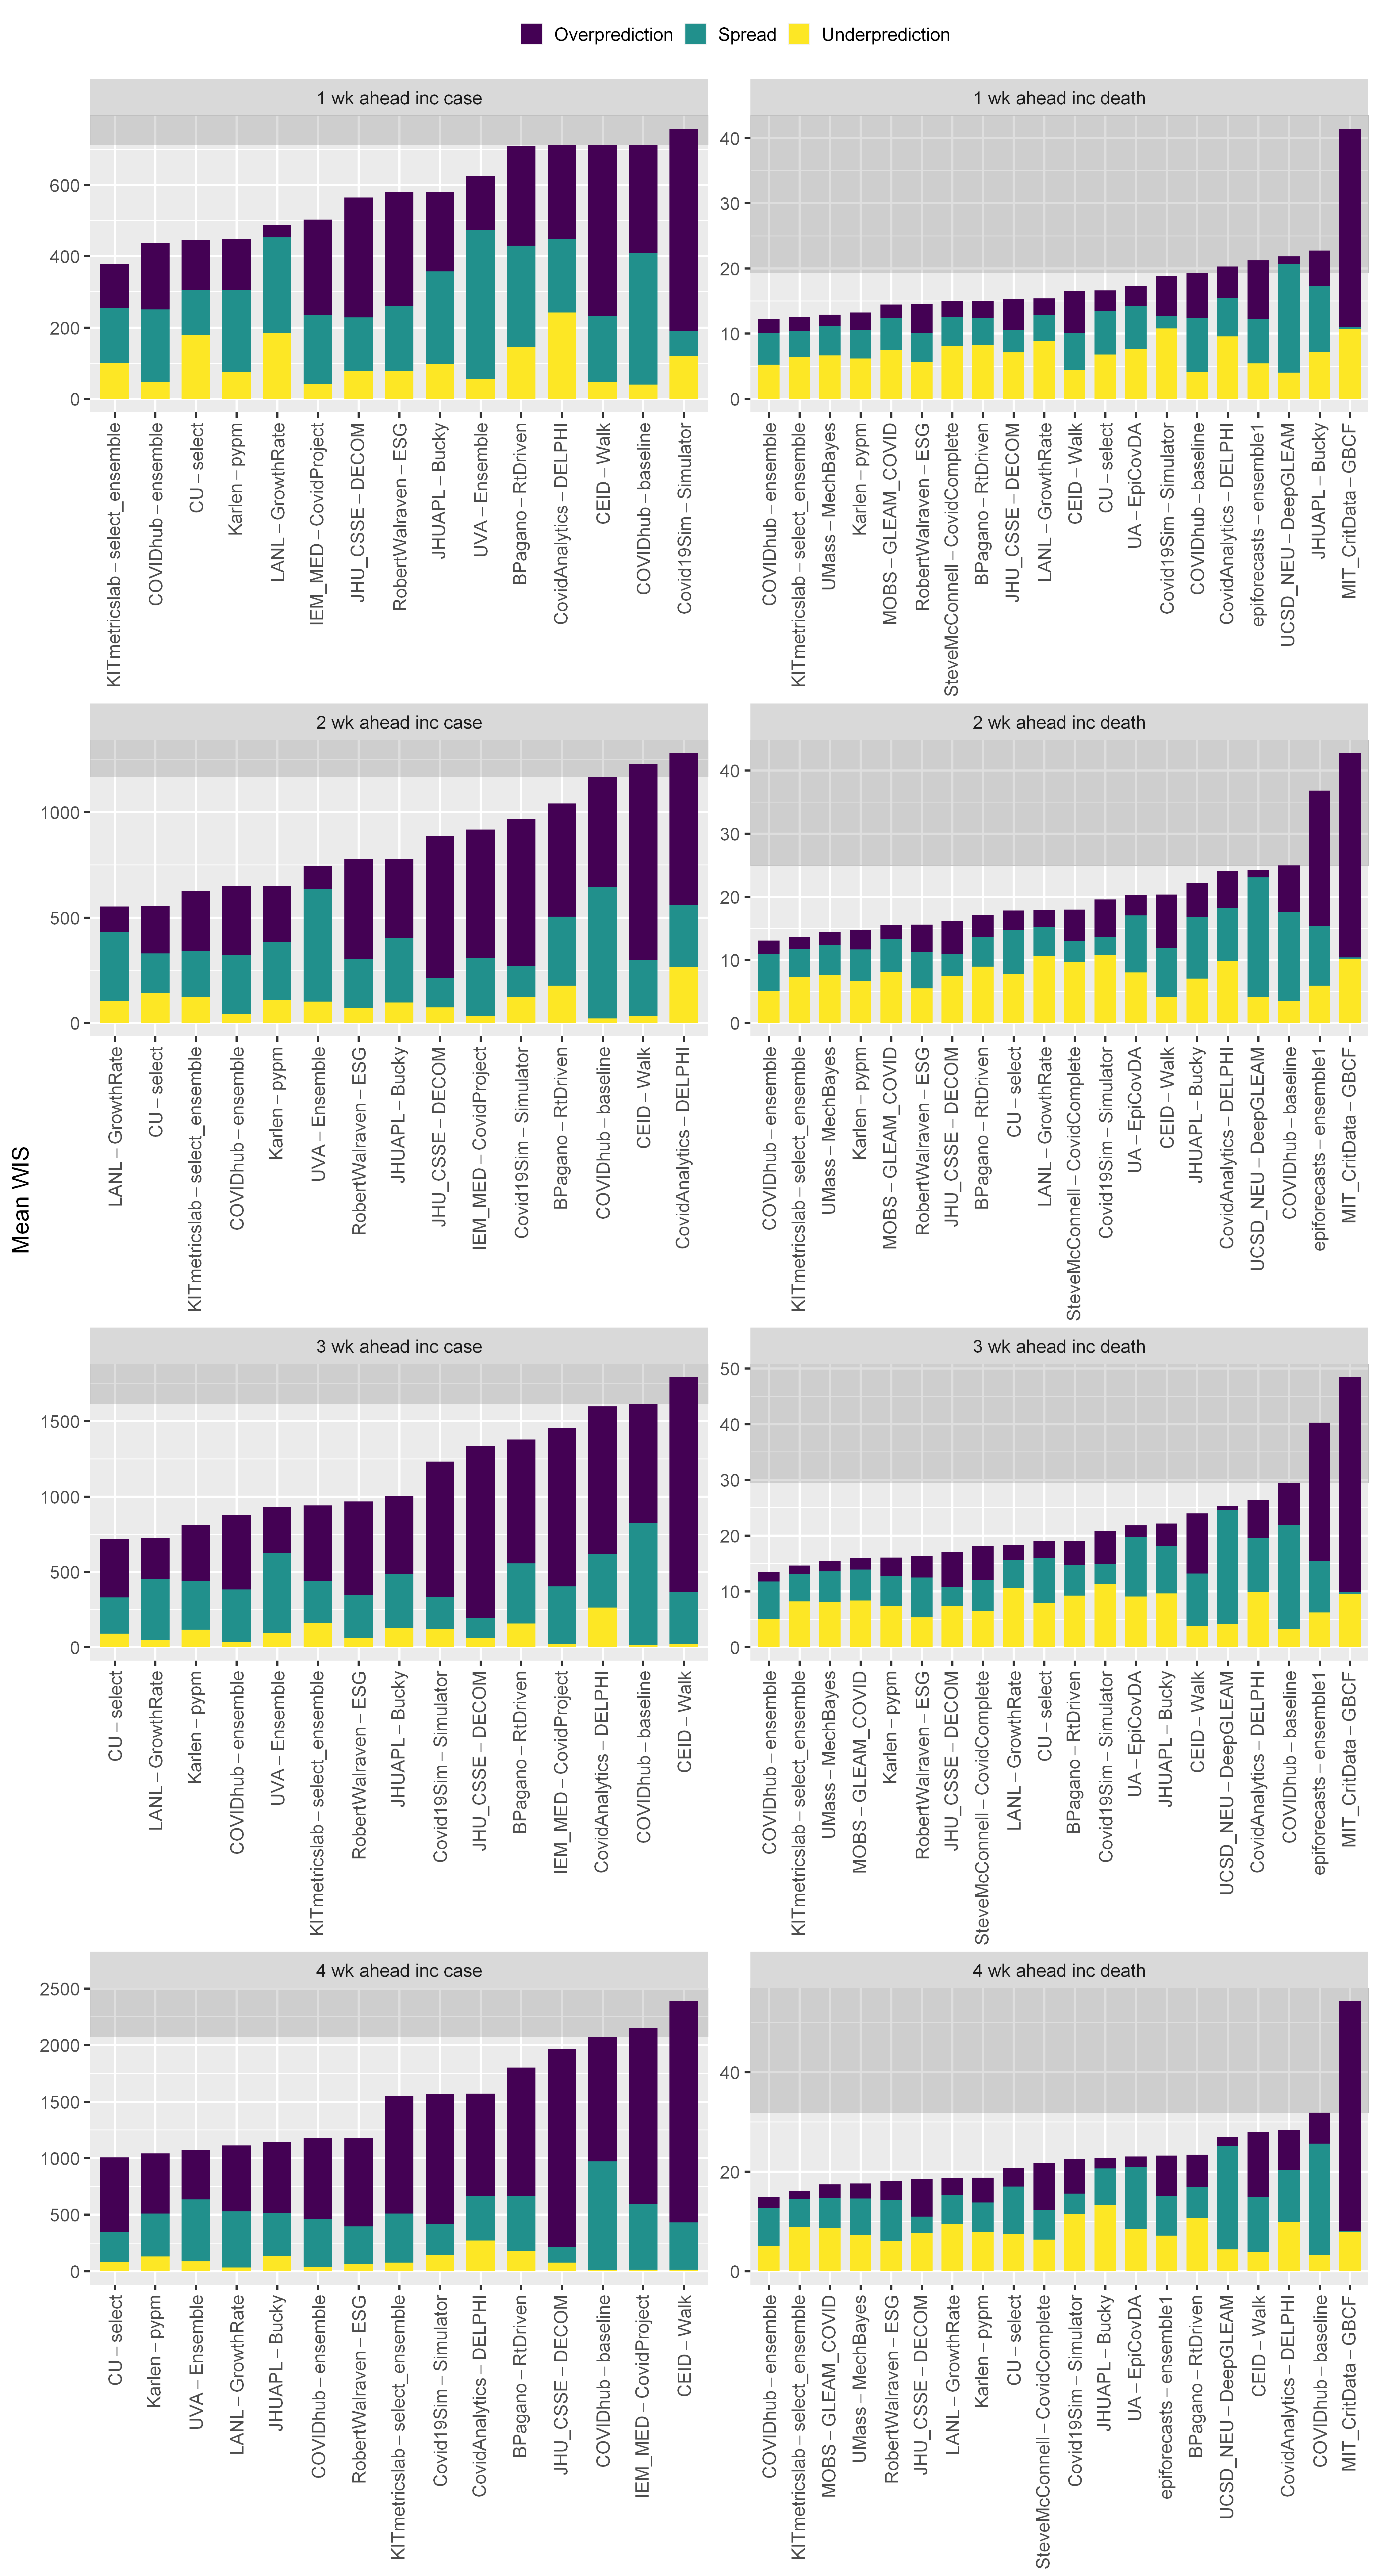

In [8]:
ggplot(subset(scores, score %in% c("wgt_pen_l", "wgt_iw", "wgt_pen_u")), 
       aes(x=reorder_within(model, value, target), y=value,
           fill=factor(score, levels=c("wgt_pen_l", "wgt_iw", "wgt_pen_u")))) +
  geom_rect(data=base_df, 
              aes(xmin=-Inf, xmax=Inf, x=NULL, ymin=mean_wis, ymax=Inf),
             size=0, color="gray", alpha=0.2, inherit.aes = FALSE) +
  geom_bar(position="stack", stat="summary", fun=mean, width=0.7) +
  scale_x_reordered() +
  facet_wrap("target", scales="free", drop=TRUE, ncol=2) +
  theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1), 
        legend.position = "top") +
  scale_fill_viridis(discrete=TRUE, name = NULL,
                     labels = c("Overprediction", "Spread", "Underprediction"))+
  labs(x = NULL,
       y = "Mean WIS")

# Mean WIS over time

The mean WIS is computed at each target end date across all states. The gray area shows the baseline performance. The ensemble methods are highlighted with thicker lines (the greenish thick line is the KITmetricslab-select_ensemble).

In [9]:
wis_by_date <- scores %>%
  filter(score == "wis") %>%
  group_by(target, model, target_end_date) %>%
  summarize(mean_WIS = mean(value))

In [10]:
wis_by_date <- wis_by_date %>%
  mutate(highlight = (model=="KITmetricslab-select_ensemble" | model=="COVIDhub-ensemble"))

In [11]:
options(repr.plot.width=15, repr.plot.height=24, repr.plot.res = 300)

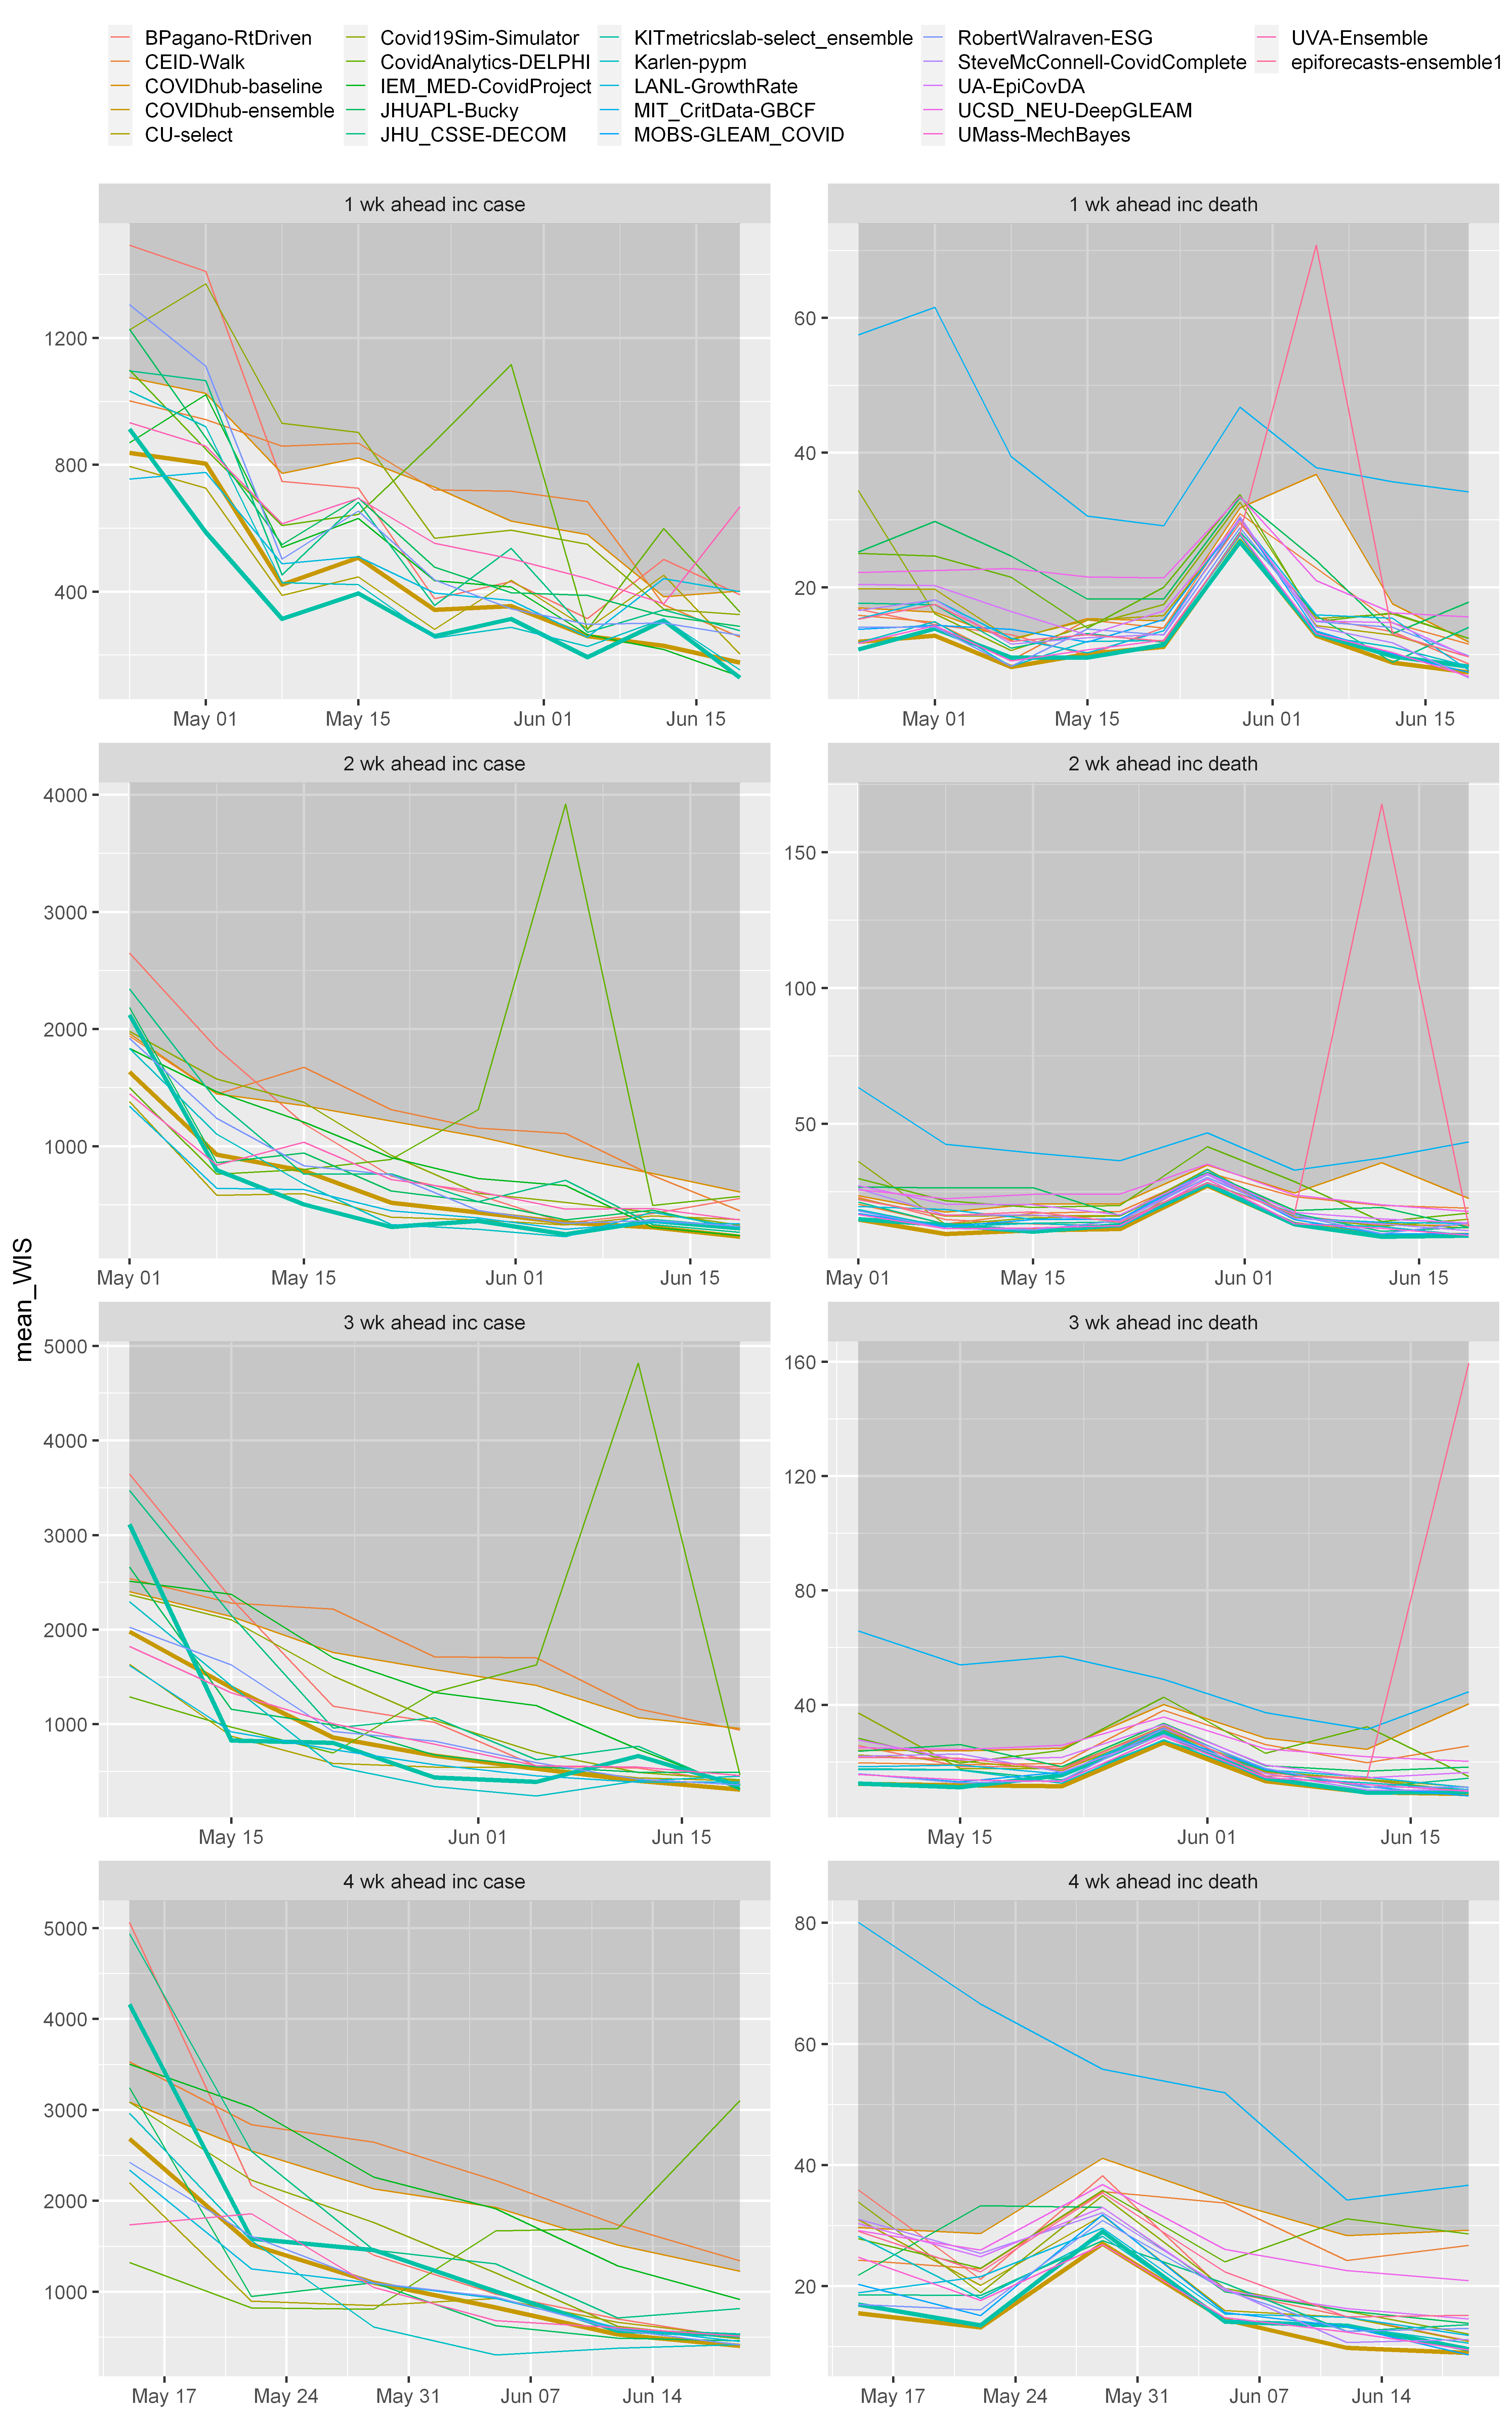

In [12]:
ggplot(wis_by_date, aes(x=target_end_date, y=mean_WIS, group=model)) +
  geom_ribbon(data = subset(wis_by_date,  model == "COVIDhub-baseline"), aes(x=target_end_date, ymin=mean_WIS, ymax=Inf),
             color="gray", alpha=0.2) + 
  geom_line(aes(color=model, size=highlight)) +
  facet_wrap("target", scales="free", ncol=2) +
  scale_size_manual(values = c("TRUE" = 1.5, "FALSE" = 0.5), guide = 'none') +
  xlab(NULL) +
  theme(legend.position = "top", legend.title=element_blank())

# Rank boxplots

The rank is computed for each location (at each date).

In [13]:
df_rank <- scores  %>% 
  filter(score == "wis") %>%
  group_by(target, target_end_date, location, model) %>%
  summarize(meanWIS = mean(value)) %>%
  group_by(target, target_end_date, location) %>%
  arrange(model, meanWIS) %>% 
  mutate(rank=rank(meanWIS)) %>%
  arrange(target_end_date)

df_rank <- df_rank %>%
  group_by(model) %>%
  mutate(meanRank=mean(rank))

In [14]:
df_rank$type <- "Individual Model"

df_rank[df_rank$model == "KITmetricslab-select_ensemble" |
        df_rank$model == "COVIDhub-ensemble", ]$type <- "Ensemble"

df_rank[df_rank$model == "COVIDhub-baseline", ]$type <- "Baseline"

In [15]:
options(repr.plot.width=16, repr.plot.height=28, repr.plot.res = 300)

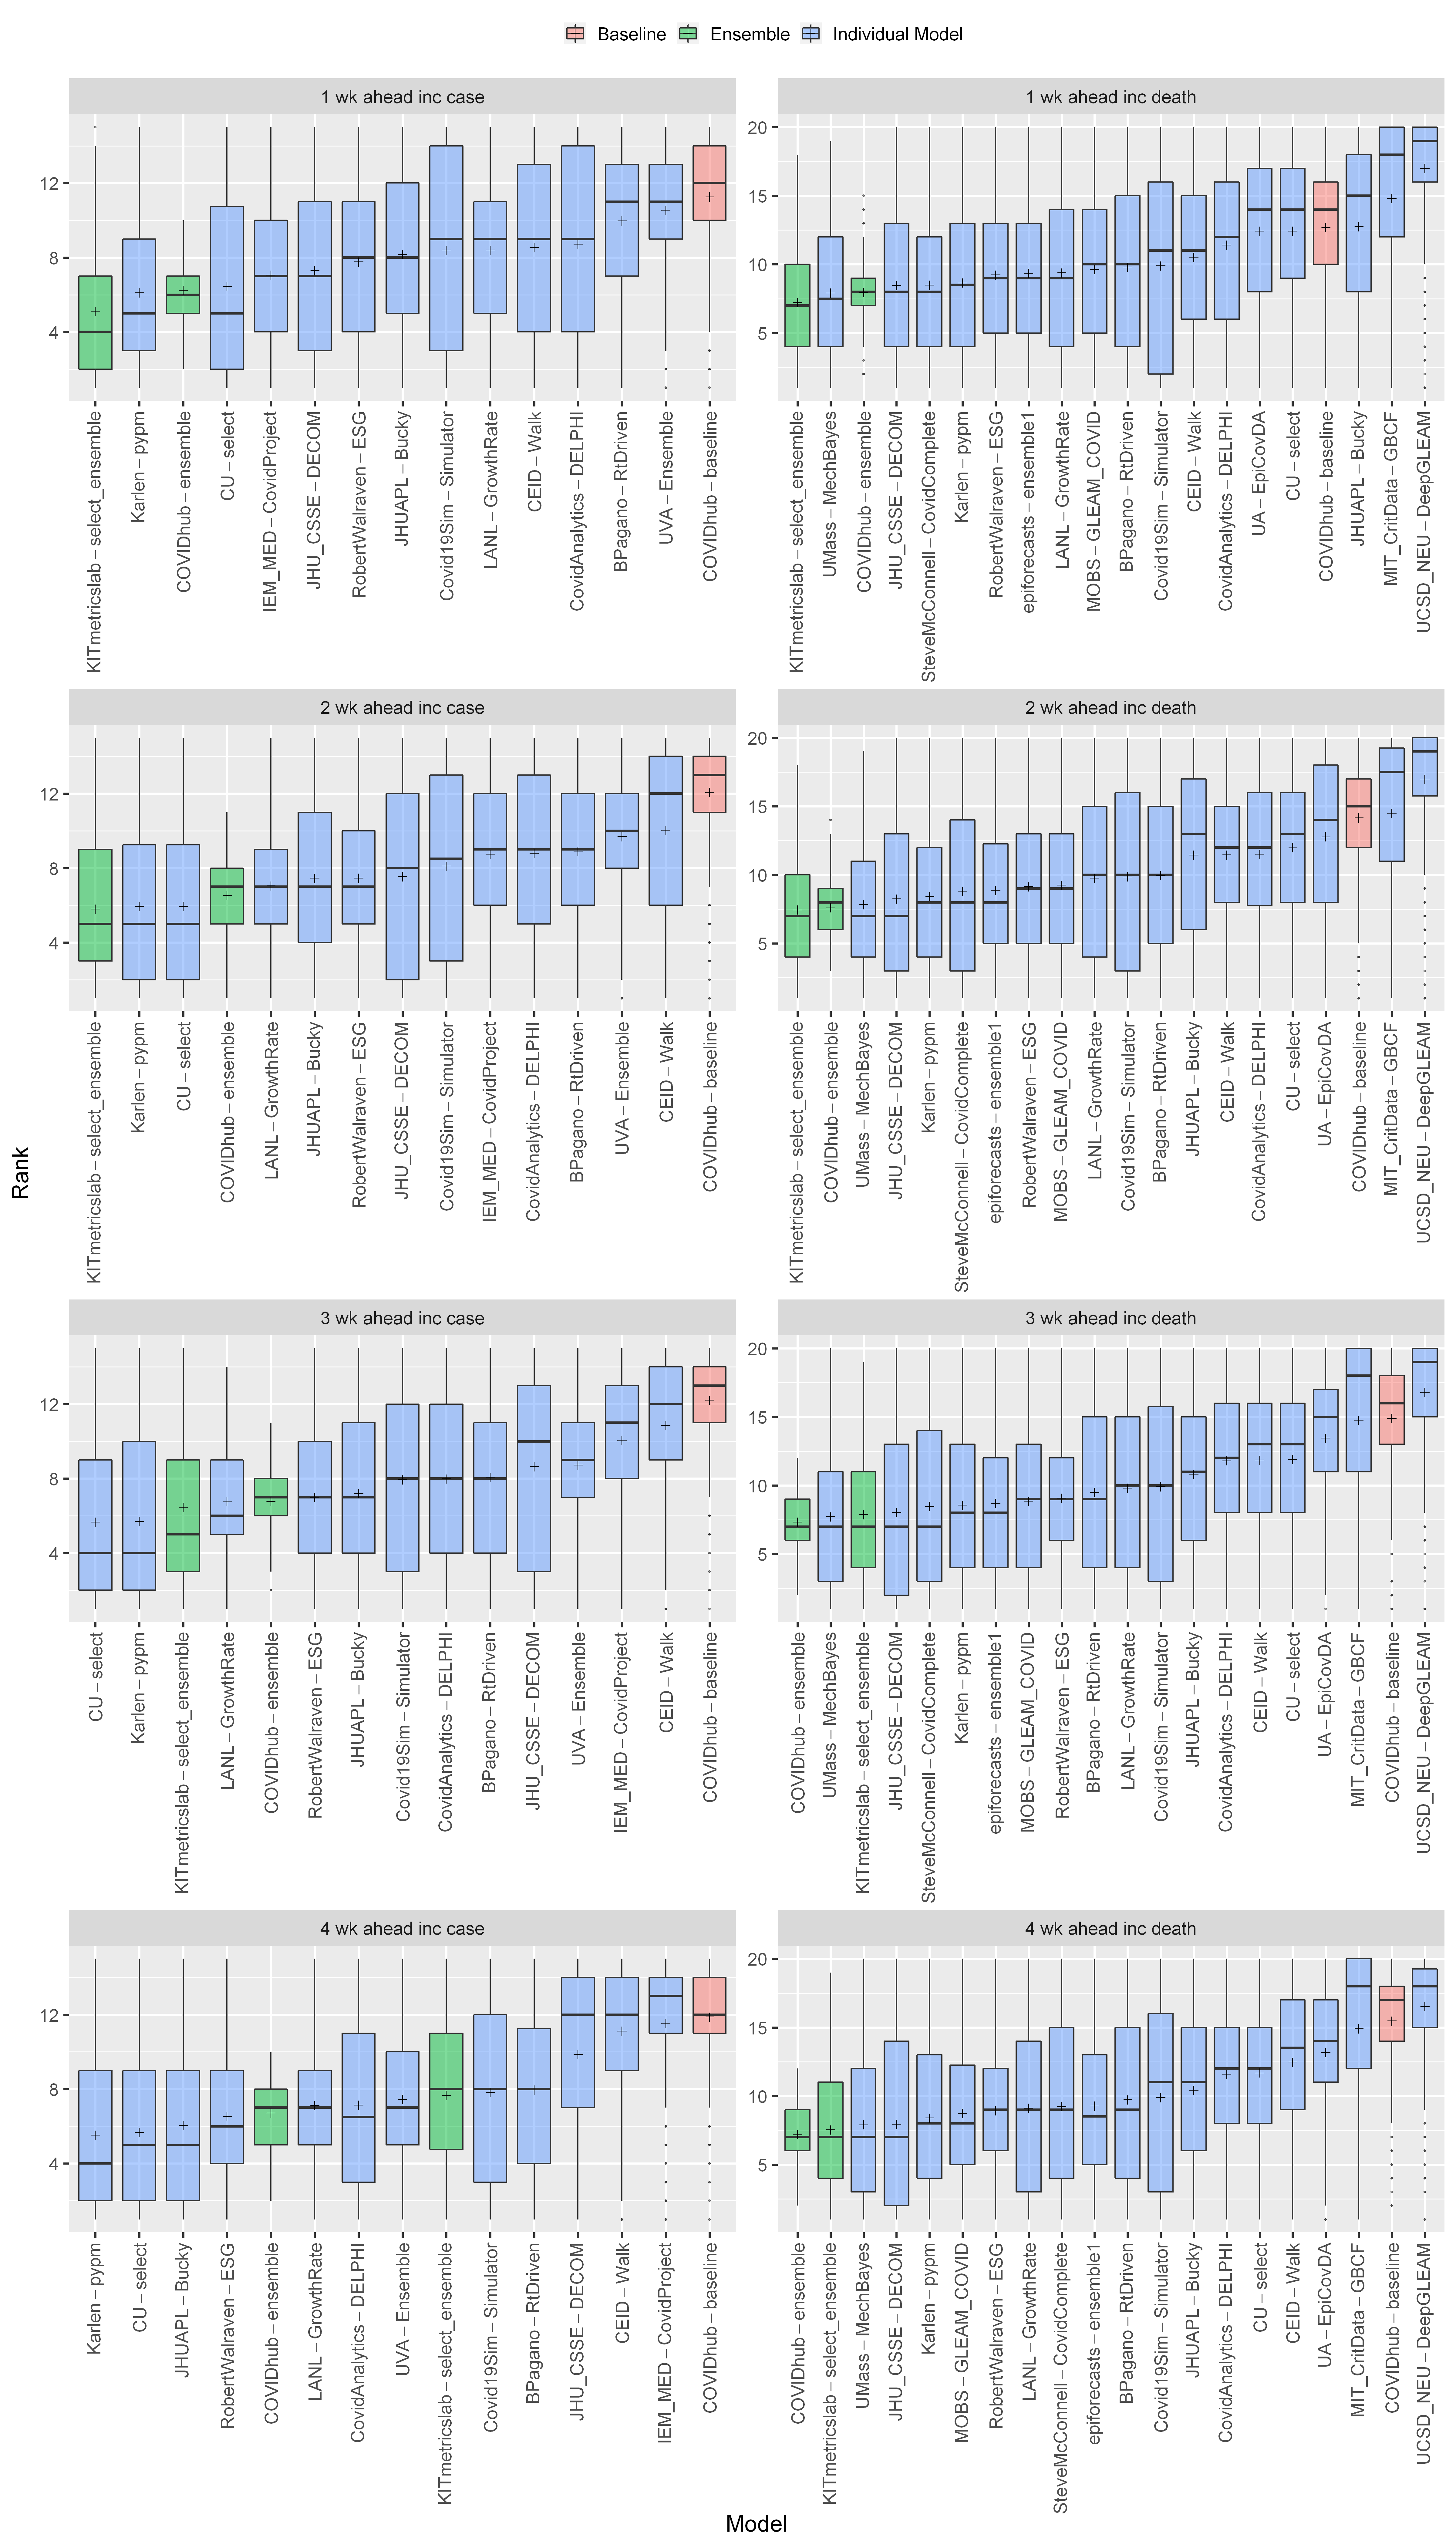

In [16]:
ggplot(df_rank, aes(x=reorder_within(model, rank, target), fill=type, y=rank)) + 
  scale_x_reordered() +
  facet_wrap("target", ncol=2, scales="free") +
  geom_boxplot(alpha=0.5, outlier.size = 0.6) +
  stat_summary(fun=mean, geom="point", shape=3, size=2) +
  xlab("Model") +
  ylab("Rank") +
  theme_gray(base_size=18) +
  theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1), 
        legend.position="top", legend.title=element_blank()) 

# Coverage Plots

In [4]:
df <- read_csv("evaluation/2021-06-19_df_processed.csv", col_types = cols())

In [24]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 300)

In [6]:
plot_coverage <- function(t="death", models=c("KITmetricslab-select_ensemble", "COVIDhub-ensemble", "COVIDhub-baseline")){
    df_temp <- df %>%
    filter(str_detect(target, t) &
          model %in% models)
    df_temp$l <- df_temp$truth < floor(df_temp$value)
    df_temp$u <- df_temp$truth <= floor(df_temp$value)

    df_temp <- df_temp %>%
        group_by(target, model, quantile) %>%
        summarize(l = mean(l), u=mean(u))

    ggplot(df_temp) +
        facet_grid(rows=vars(target), cols=vars(model)) +
        geom_segment(aes(x=0,xend=1,y=0,yend=1), linetype="dashed", colour="grey70")+
        geom_errorbar(aes(x=quantile, ymin=l, ymax=u), width=0.05, size=0.5,
                      data=df_temp, colour="black") +
        scale_x_continuous(breaks = c(0, 0.25, 0.5, 0.75, 1),
                           labels = function(x) ifelse(x == 0, "0", x)) +
        scale_y_continuous(labels = function(y) ifelse(y == 0, "0", y)) +
        xlab('Quantile') +
        ylab('') +
        labs(title=paste0(str_to_title(t), "s"))
}

`summarise()` has grouped output by 'target', 'model'. You can override using the `.groups` argument.



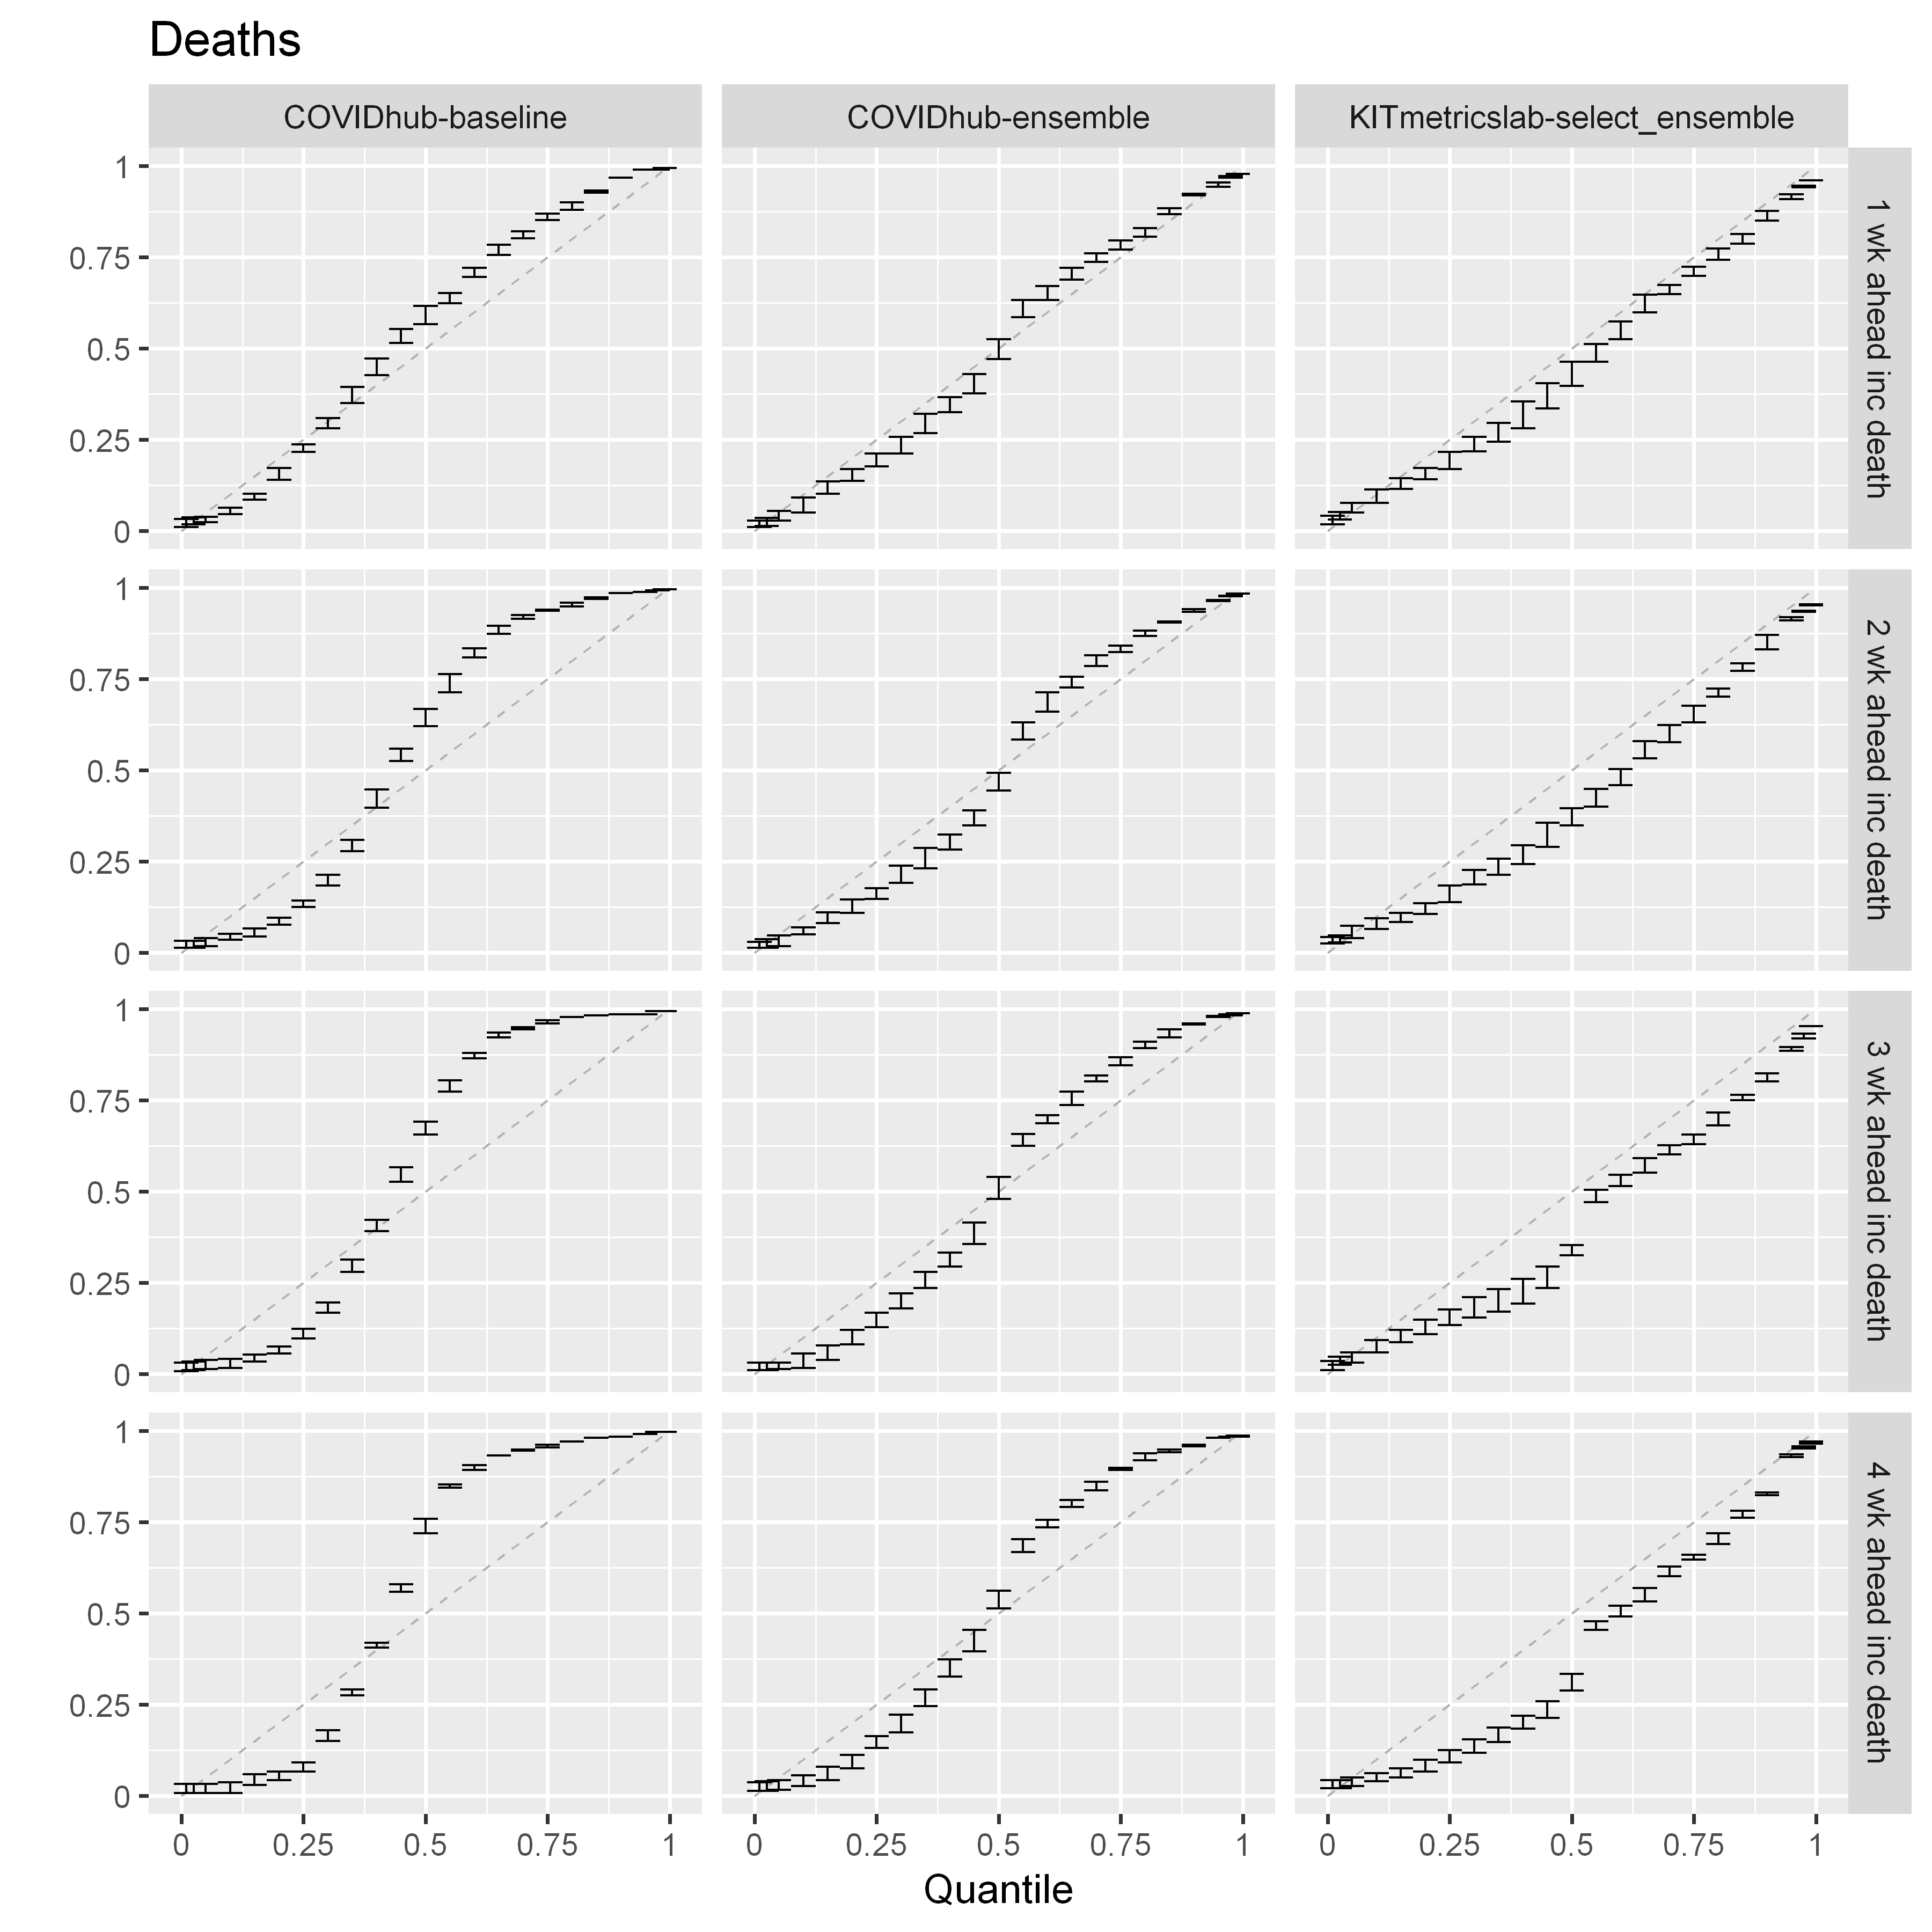

In [7]:
plot_coverage("death")

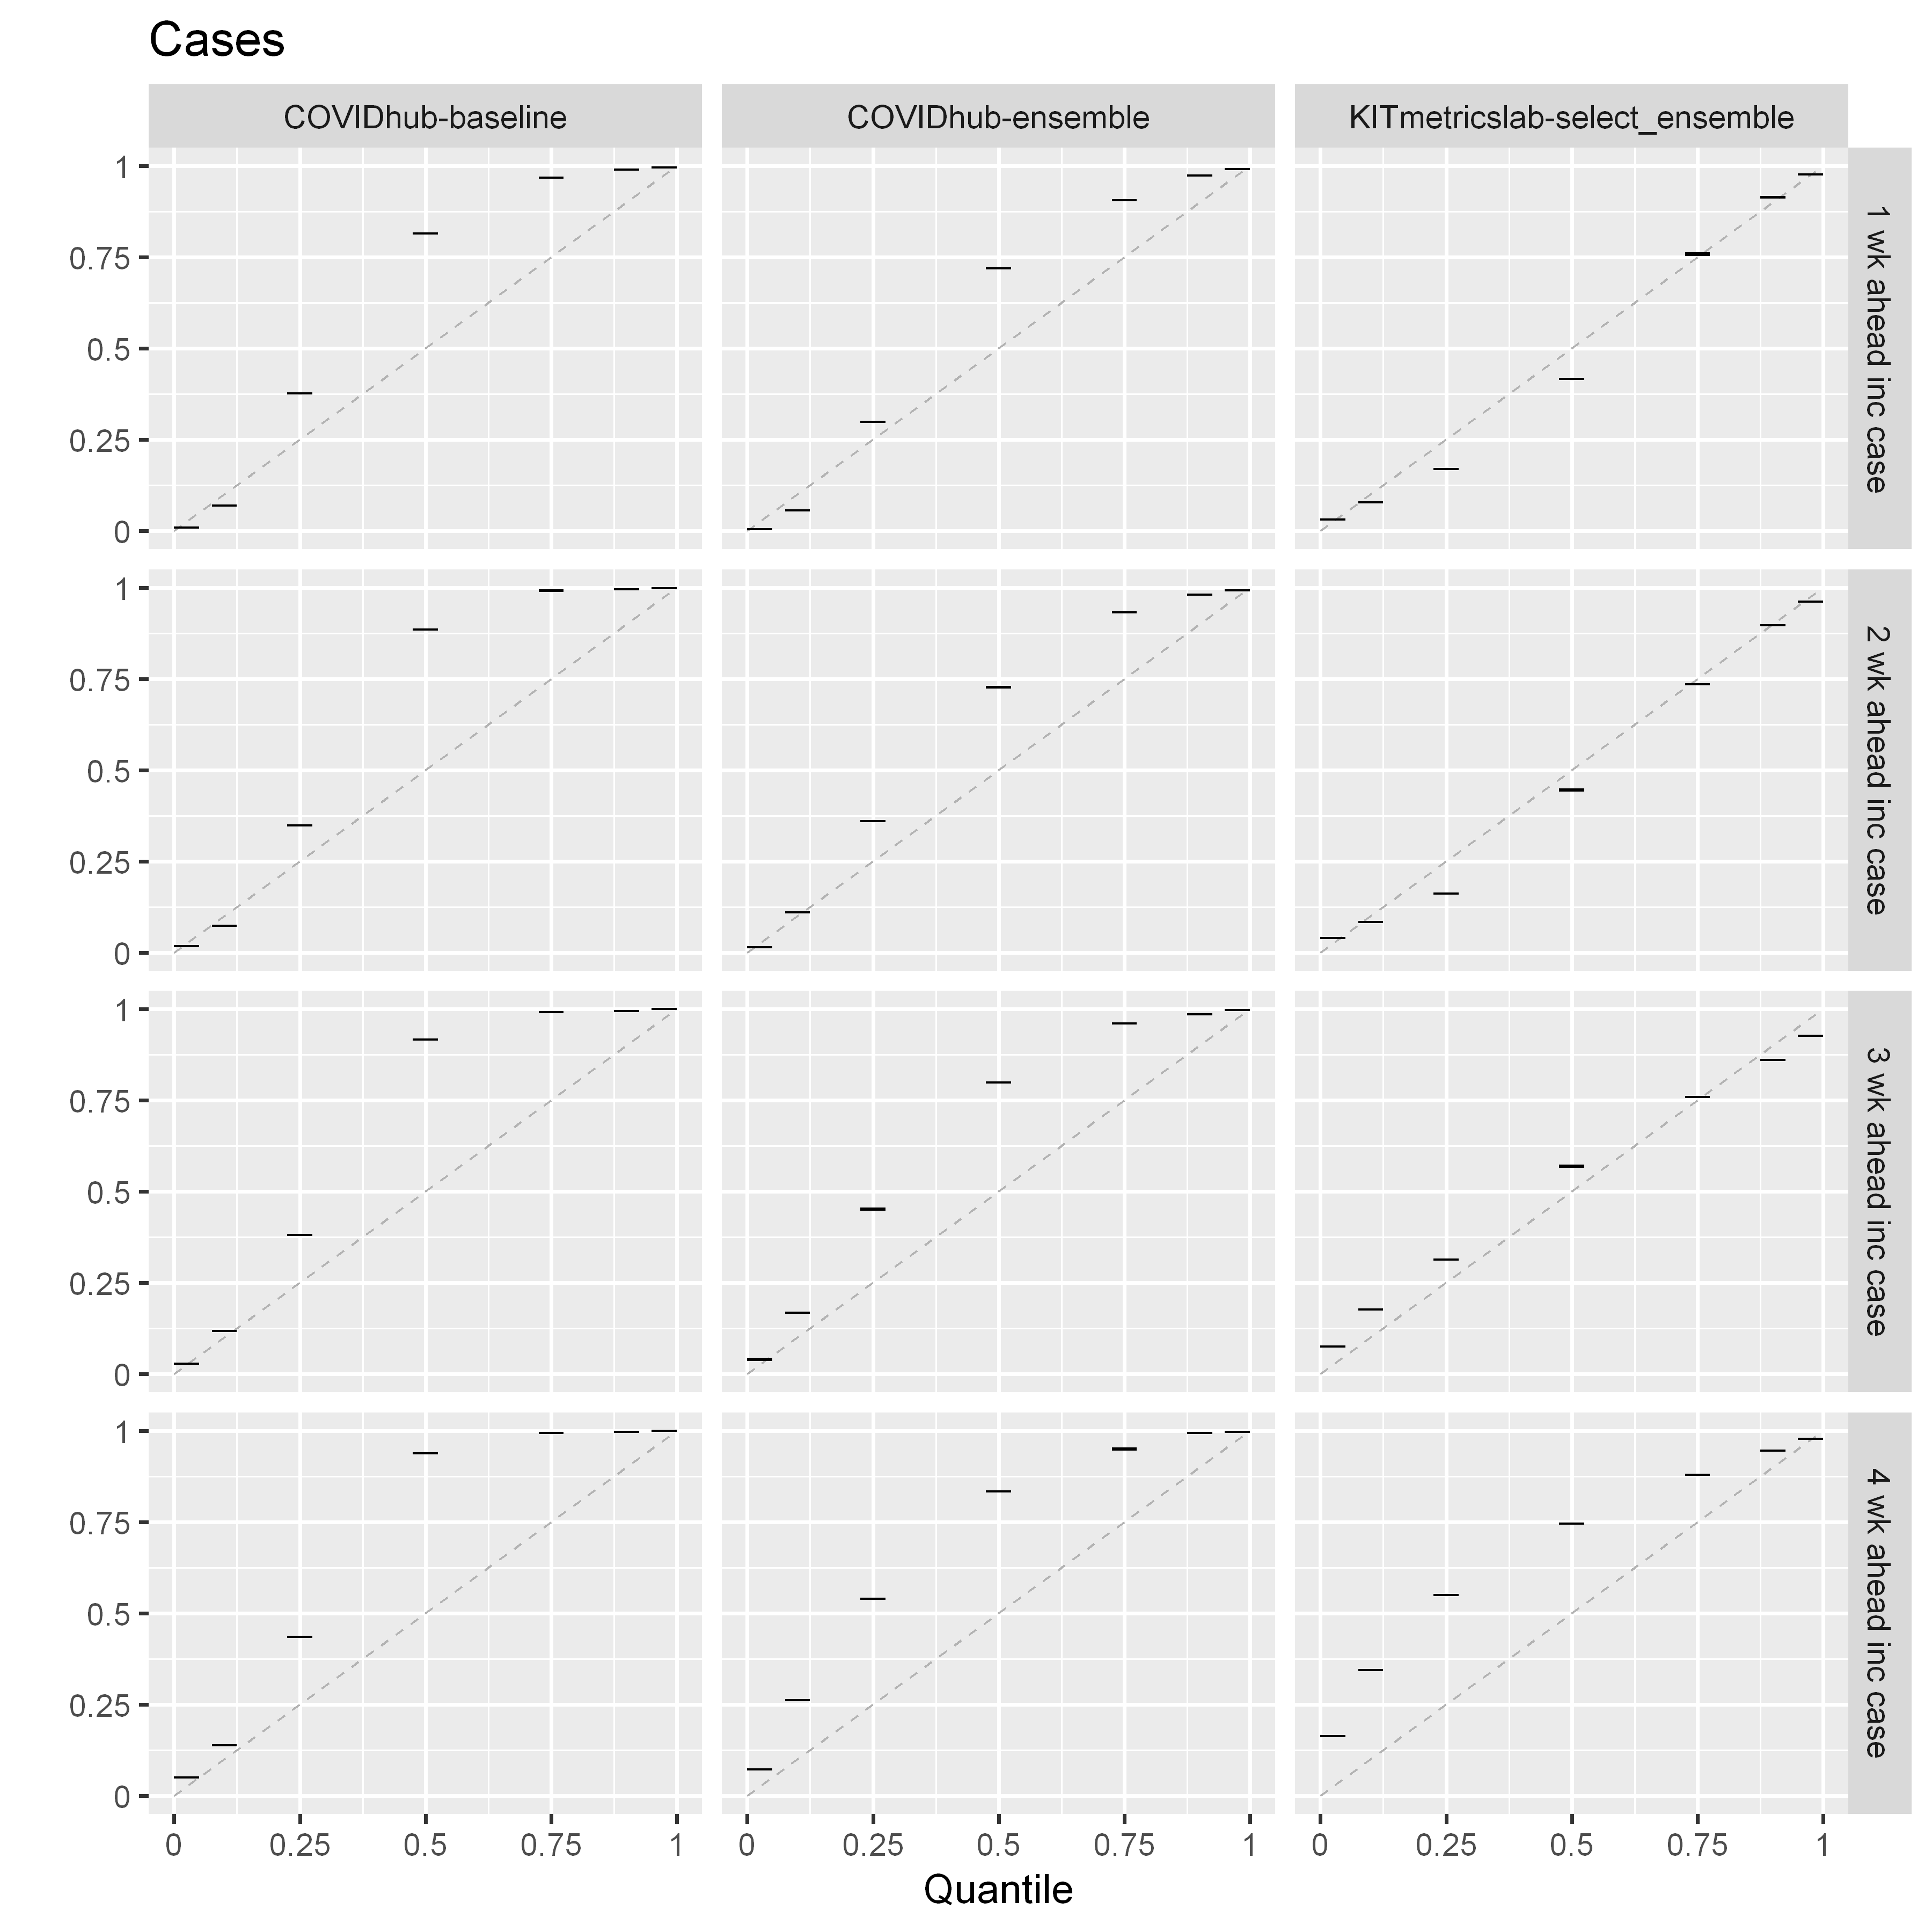

In [21]:
plot_coverage("case")

# Murphy Diagrams

In [6]:
library(murphydiagram)

In [7]:
df <- read.csv("evaluation/2021-06-12_df_processed.csv") %>%
  filter(location != "US")

In [8]:
model1 = "KITmetricslab-select_ensemble"
model2 = "COVIDhub-baseline"
alpha = 0.5

In [6]:
df1 <- df %>%
filter(quantile == alpha)

f1 <- subset(df1, model == model1)$value
f2 <- subset(df1, model == model2)$value
y <- subset(df1, model == "COVIDhub-baseline")$truth

In [7]:
elementary_quantile_score <- function(y_true, y_pred, theta, alpha){
    ((y_true < y_pred) - alpha) * ((theta < y_pred) - (theta < y_true))
}

In [28]:
((df2$truth < df2$value) - df2$alpha)

integer(0)

In [36]:
((df2$truth < df2$value) - df2$quantile) * ((100 < df2$value) - (100 < df2$truth))

[1] 0.025 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
   [13] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.250
   [25] 0.200 0.150 0.100 0.050 0.025 0.010 0.000 0.000 0.000 0.000 0.000 0.000
   [37] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
   [49] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
   [61] 0.025 0.100 0.000 0.000 0.000 0.000 0.000 0.010 0.025 0.050 0.100 0.150
   [73] 0.200 0.250 0.300 0.350 0.400 0.450 0.500 0.550 0.600 0.650 0.700 0.750
   [85] 0.000 0.000 0.000 0.000 0.000 0.000 0.025 0.100 0.000 0.000 0.000 0.000
   [97] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [109] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.050 0.025 0.010
  [121] 0.025 0.000 0.000 0.000 0.000 0.000 0.000 0.010 0.025 0.050 0.000 0.000
  [133] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [145] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [157] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [169] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.050 0.025 0.010
  [181] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [193] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [205] 0.000 0.000 0.100 0.050 0.025 0.010 0.000 0.000 0.000 0.000 0.000 0.000
  [217] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [229] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [241] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.010 0.000 0.000 0.000 0.000
  [253] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [265] 0.000 0.000 0.000 0.000 0.000 0.000 0.025 0.000 0.000 0.000 0.000 0.000
  [277] 0.000 0.010 0.025 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [289] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [301] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [313] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [325] 0.000 0.000 0.000 0.000 0.000 0.000 0.025 0.000 0.000 0.000 0.000 0.000
  [337] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [349] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [361] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.010 0.025 0.050 0.100 0.150
  [373] 0.200 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [385] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [397] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [409] 0.000 0.000 0.000 0.000 0.000 0.250 0.200 0.150 0.100 0.050 0.025 0.010
  [421] 0.025 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [433] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [445] 0.000 0.000 0.000 0.050 0.025 0.010 0.025 0.100 0.000 0.000 0.000 0.000
  [457] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [469] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.050 0.025 0.010
  [481] 0.025 0.000 0.000 0.000 0.000 0.000 0.000 0.010 0.025 0.050 0.100 0.150
  [493] 0.200 0.250 0.300 0.350 0.400 0.450 0.500 0.550 0.600 0.650 0.000 0.000
  [505] 0.000 0.000 0.000 0.000 0.000 0.000 0.025 0.100 0.000 0.000 0.000 0.000
  [517] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [529] 0.000 0.000 0.000 0.000 0.000 0.000 0.200 0.150 0.100 0.050 0.025 0.010
  [541] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [553] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [565] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [577] 0.000 0.010 0.025 0.050 0.100 0.150 0.200 0.250 0.300 0.350 0.400 0.450
  [589] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [6

In [34]:
c <- elementary_quantile_score(df2$truth, df2$value, 200, df2$quantile)

In [35]:
c

[1] 0.025 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
   [13] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
   [25] 0.000 0.000 0.000 0.050 0.025 0.010 0.000 0.000 0.000 0.000 0.000 0.000
   [37] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
   [49] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
   [61] 0.025 0.100 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
   [73] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
   [85] 0.000 0.000 0.000 0.050 0.025 0.010 0.025 0.100 0.000 0.000 0.000 0.000
   [97] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [109] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.010
  [121] 0.025 0.000 0.000 0.000 0.000 0.000 0.000 0.010 0.025 0.050 0.000 0.000
  [133] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [145] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [157] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [169] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.010
  [181] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [193] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [205] 0.000 0.000 0.000 0.000 0.025 0.010 0.000 0.000 0.000 0.000 0.000 0.000
  [217] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [229] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [241] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.010 0.025 0.050 0.000 0.000
  [253] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [265] 0.000 0.000 0.000 0.000 0.000 0.000 0.025 0.000 0.000 0.000 0.000 0.000
  [277] 0.000 0.010 0.025 0.050 0.100 0.150 0.000 0.000 0.000 0.000 0.000 0.000
  [289] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [301] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [313] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [325] 0.000 0.000 0.000 0.000 0.000 0.000 0.025 0.000 0.000 0.000 0.000 0.000
  [337] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [349] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [361] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [373] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.300 0.250
  [385] 0.200 0.150 0.100 0.050 0.025 0.010 0.000 0.000 0.000 0.000 0.000 0.000
  [397] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [409] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.025 0.010
  [421] 0.025 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [433] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [445] 0.000 0.000 0.000 0.000 0.025 0.010 0.025 0.100 0.000 0.000 0.000 0.000
  [457] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [469] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.010
  [481] 0.025 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [493] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [505] 0.000 0.000 0.000 0.000 0.000 0.010 0.025 0.100 0.000 0.000 0.000 0.000
  [517] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [529] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.010
  [541] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [553] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [565] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [577] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  [589] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.010
  [6

In [ ]:
murphy_scores(df2$truth, df2$value, thetas, df2$quantile)

In [8]:
murphy_scores <- function(y_true, y_pred, thetas, alpha){
    scores <- list()
    for(t in thetas){
        scores[[paste0("s", t)]] <- elementary_quantile_score(y_true, y_pred, t, alpha)
    }
    return(scores)
}

In [9]:
s <- murphy_scores(df1$truth, df1$value, c(0.5, 1, 10), 0.5)

In [96]:
s <- murphy_scores(df1$truth, df1$value, sort(unique(c(df2$value, df2$truth))), 0.5)

In [10]:
s

$s0.5
    [1] 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   [19] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   [37] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   [55] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   [73] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   [91] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [109] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [127] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [145] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [163] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [181] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [199] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [217] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [235] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [253] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [271] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [289] 0.0 0.5 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [307] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [325] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [343] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [361] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [379] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [397] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [415] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [433] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [451] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [469] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [487] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [505] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [523] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [541] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [559] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [577] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [595] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [613] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [631] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [649] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [667] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [685] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [703] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [721] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [739] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [757] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [775] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [793] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [811] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [829] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [847] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [865] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  [883] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

In [71]:
a <- df1 %>%
    mutate(s = elementary_quantile_score(value, truth, -3, quantile))

In [11]:
df2 <- df1 %>%
  filter(model == model1 | model == model2)

In [33]:
df2 <- df %>%
  filter(model == model1 | model == model2)

In [88]:
a <- df2 %>%
    rowwise %>% 
    mutate(scores = list(murphy_scores(value, truth, c(0.5, 1, 10), quantile)))%>% 
    unnest_wider(scores)

In [12]:
thetas <- sort(unique(c(df2$value, df2$truth)))

In [13]:
a <- df2 %>%
    rowwise %>% 
    mutate(scores = list(murphy_scores(value, truth, thetas, quantile)))%>% 
    unnest_wider(scores)

In [14]:
a

target_end_date target               location quantile value       
1    2021-04-24      1 wk ahead inc case  01       0.5       3543       
2    2021-04-24      1 wk ahead inc death 01       0.5         78       
3    2021-04-24      1 wk ahead inc case  02       0.5       1139       
4    2021-04-24      1 wk ahead inc death 02       0.5         21       
5    2021-04-24      1 wk ahead inc case  04       0.5       4029       
6    2021-04-24      1 wk ahead inc death 04       0.5         59       
7    2021-04-24      1 wk ahead inc case  05       0.5       1354       
8    2021-04-24      1 wk ahead inc death 05       0.5         32       
9    2021-04-24      1 wk ahead inc case  06       0.5      19599       
10   2021-04-24      1 wk ahead inc death 06       0.5        610       
11   2021-04-24      1 wk ahead inc case  08       0.5      11585       
12   2021-04-24      1 wk ahead inc death 08       0.5         33       
13   2021-04-24      1 wk ahead inc case  09       0.5       7476       
14   2021-04-24      1 wk ahead inc death 09       0.5         51       
15   2021-04-24      1 wk ahead inc case  10       0.5       2574       
16   2021-04-24      1 wk ahead inc death 10       0.5         25       
17   2021-04-24      1 wk ahead inc case  12       0.5      43354       
18   2021-04-24      1 wk ahead inc death 12       0.5        390       
19   2021-04-24      1 wk ahead inc case  13       0.5      10600       
20   2021-04-24      1 wk ahead inc death 13       0.5        269       
21   2021-04-24      1 wk ahead inc case  15       0.5        672       
22   2021-04-24      1 wk ahead inc death 15       0.5          3       
23   2021-04-24      1 wk ahead inc case  16       0.5       1616       
24   2021-04-24      1 wk ahead inc death 16       0.5         24       
25   2021-04-24      1 wk ahead inc case  17       0.5      22751       
26   2021-04-24      1 wk ahead inc death 17       0.5        168       
27   2021-04-24      1 wk ahead inc case  18       0.5       9578       
28   2021-04-24      1 wk ahead inc death 18       0.5         78       
29   2021-04-24      1 wk ahead inc case  19       0.5       2942       
30   2021-04-24      1 wk ahead inc death 19       0.5         24       
...  ...             ...                  ...      ...      ...         
5171 2021-06-12      2 wk ahead inc case  53       0.5      5583.4842421
5172 2021-06-12      2 wk ahead inc death 53       0.5        57.9939448
5173 2021-06-12      3 wk ahead inc case  53       0.5      1244.2386814
5174 2021-06-12      3 wk ahead inc death 53       0.5        50.5480828
5175 2021-06-12      4 wk ahead inc case  53       0.5      4091.0560050
5176 2021-06-12      4 wk ahead inc death 53       0.5        37.2186345
5177 2021-06-12      1 wk ahead inc case  54       0.5       828.1622402
5178 2021-06-12      1 wk ahead inc death 54       0.5        16.6132582
5179 2021-06-12      2 wk ahead inc case  54       0.5       822.2291784
5180 2021-06-12      2 wk ahead inc death 54       0.5        14.8937935
5181 2021-06-12      3 wk ahead inc case  54       0.5       447.8523153
5182 2021-06-12      3 wk ahead inc death 54       0.5        18.2970096
5183 2021-06-12      4 wk ahead inc case  54       0.5      1009.4941361
5184 2021-06-12      4 wk ahead inc death 54       0.5        15.7736890
5185 2021-06-12      1 wk ahead inc case  55       0.5       896.4092148
5186 2021-06-12      1 wk ahead inc death 55       0.5        47.7368158
5187 2021-06-12      2 wk ahead inc case  55       0.5       990.9289478
5188 2021-06-12      2 wk ahead inc death 55       0.5        36.9319783
5189 2021-06-12      3 wk ahead inc case  55       0.5      1146.9156508
5190 2021-06-12      3 wk ahead inc death 55       0.5        33.7123359
5191 2021-06-12      4 wk ahead inc case  55       0.5      1431.3846083
5192 2021-06-12      4 wk ahead inc death 55       0.5        33.5798323
5193 2021-06-12      1 wk ahead inc case  56       0.5       38

In [57]:
a %>%
    group_by(model) %>%
    summarize(mean_score = mean(s))

model                         mean_score 
1  BPagano-RtDriven              0.001923077
2  CEID-Walk                     0.001923077
3  COVIDhub-baseline             0.001923077
4  COVIDhub-ensemble             0.001923077
5  CU-select                     0.001923077
6  Covid19Sim-Simulator          0.001923077
7  CovidAnalytics-DELPHI         0.001923077
8  DDS-NBDS                      0.003846154
9  IEM_MED-CovidProject          0.000000000
10 JHUAPL-Bucky                  0.001923077
11 JHU_CSSE-DECOM                0.001923077
12 KITmetricslab-select_ensemble 0.001923077
13 Karlen-pypm                   0.001923077
14 LANL-GrowthRate               0.001923077
15 LNQ-ens1                      0.001923077
16 MIT_CritData-GBCF             0.003846154
17 MOBS-GLEAM_COVID              0.003846154
18 RobertWalraven-ESG            0.001923077
19 SteveMcConnell-CovidComplete  0.003846154
20 UA-EpiCovDA                   0.003846154
21 UCSD_NEU-DeepGLEAM            0.003846154
22 UChicagoCHATTOPADHYAY-UnIT    0.000000000
23 UMass-MechBayes               0.003846154
24 USC-SI_kJalpha                0.001923077
25 UVA-Ensemble                  0.000000000
26 epiforecasts-ensemble1        0.003846154

In [52]:
max(a$s)

[1] 0.5

In [16]:
aux <- c(f1, f2, y)

In [17]:
#get_grid(f1, f2, y, "quantile", 0.5)

In [37]:
# Input checker needed below
input.check <- function(f, y, t, alpha){
  if ( (length(t) > 1) | (length(alpha) > 1) | (length(f) != length(y)) | any(c(!is.vector(f), !is.vector(y), !is.vector(t), !is.vector(alpha))) ) stop("invalid input") 
}

# Extremal score for quantiles
S.quantile <- function(f, y, t, alpha){
  input.check(f, y, t, alpha)
  ((y < f) - alpha) * ((t < f) - (t < y))
}

In [38]:
get_grid <- function(f1, f2, y, functional, alpha, literal = TRUE, lhdiff = 1e-10){
  if (literal == TRUE){
    # Choose range of t's (see Corollary 2a, 2b in paper)
    if (functional == "quantile"){
      tseq <- sort(unique(c(f1, f2, y)))
    } else if (functional == "expectile") {
      # NOTE: Use y's for Murphy diagrams also in case alpha = 1/2, even if not strictly needed
      aux1 <- sort(unique(c(f1, f2, y)))
      aux2 <- sort(unique(c(f1, f2))) - lhdiff
      tseq <- sort(unique(c(aux1, aux2)))   
    }
  } else {
    # Simply choose equally spaced grid of fixed length
    aux <- c(f1, f2, y)
    tseq <- seq(from = min(aux) - 0.1*sd(aux), to = max(aux) + 0.1*sd(aux), length.out = 100)
  }
  tseq
}

In [39]:
murphydiagram <- function(f1, f2, y, functional = "expectile", alpha = 0.5, labels = c("Method 1", "Method 2"), 
                          colors = NULL, equally_spaced = FALSE){
  cex.gen <- 1.6
  # Define function for extremal score
  if (functional == "expectile"){
    g <- function(f, t) S.expectile(f, y, t, alpha)
  } else if (functional == "quantile"){
    g <- function(f, t) S.quantile(f, y, t, alpha)
  } else {
    stop("Please choose either expectile or quantile functional")
  }
  # Unless specified otherwise: Use colors as in paper
  if (is.null(colors)) colors <- c("#D55E00", "#56B4E9", "#000000")
  # Grid of theta values
  tseq <- get_grid(f1, f2, y, functional, alpha, literal =  1 - equally_spaced)
  # Data frame with score entries for all theta values
  df <- data.frame(tseq = tseq, s1 = numeric(length(tseq)), s2 = numeric(length(tseq)))
  for (j in 1:length(tseq)){
    aux1 <- g(f1, tseq[j])
    aux2 <- g(f2, tseq[j])
    df[j, 2:3] <- c(mean(aux1), mean(aux2))
  }
  # Plot: Scores for both methods
  if (all(y %in% c(0, 1))){
    xx <- c(-0.05, 1.05)
  } else {
    xx <- c(min(tseq) - 0.1, max(tseq) + 0.1)
  }
  matplot(x = tseq, y = df[,2:3], type = "l", lty = 1, lwd = 4, xlab = expression(paste("Parameter ", theta)), ylab = "", bty = "n", cex.lab = cex.gen, 
          cex.axis = cex.gen, xlim = xx, ylim = c(0, 1.2*max(df[,2:3])), col = colors)
  abline(h = 0, lty = 2)
  if (!is.null(labels)) legend("topright", labels, col = colors, lwd = 4, bty = "n", horiz = FALSE, cex = 1)
  
}

In [40]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 300)

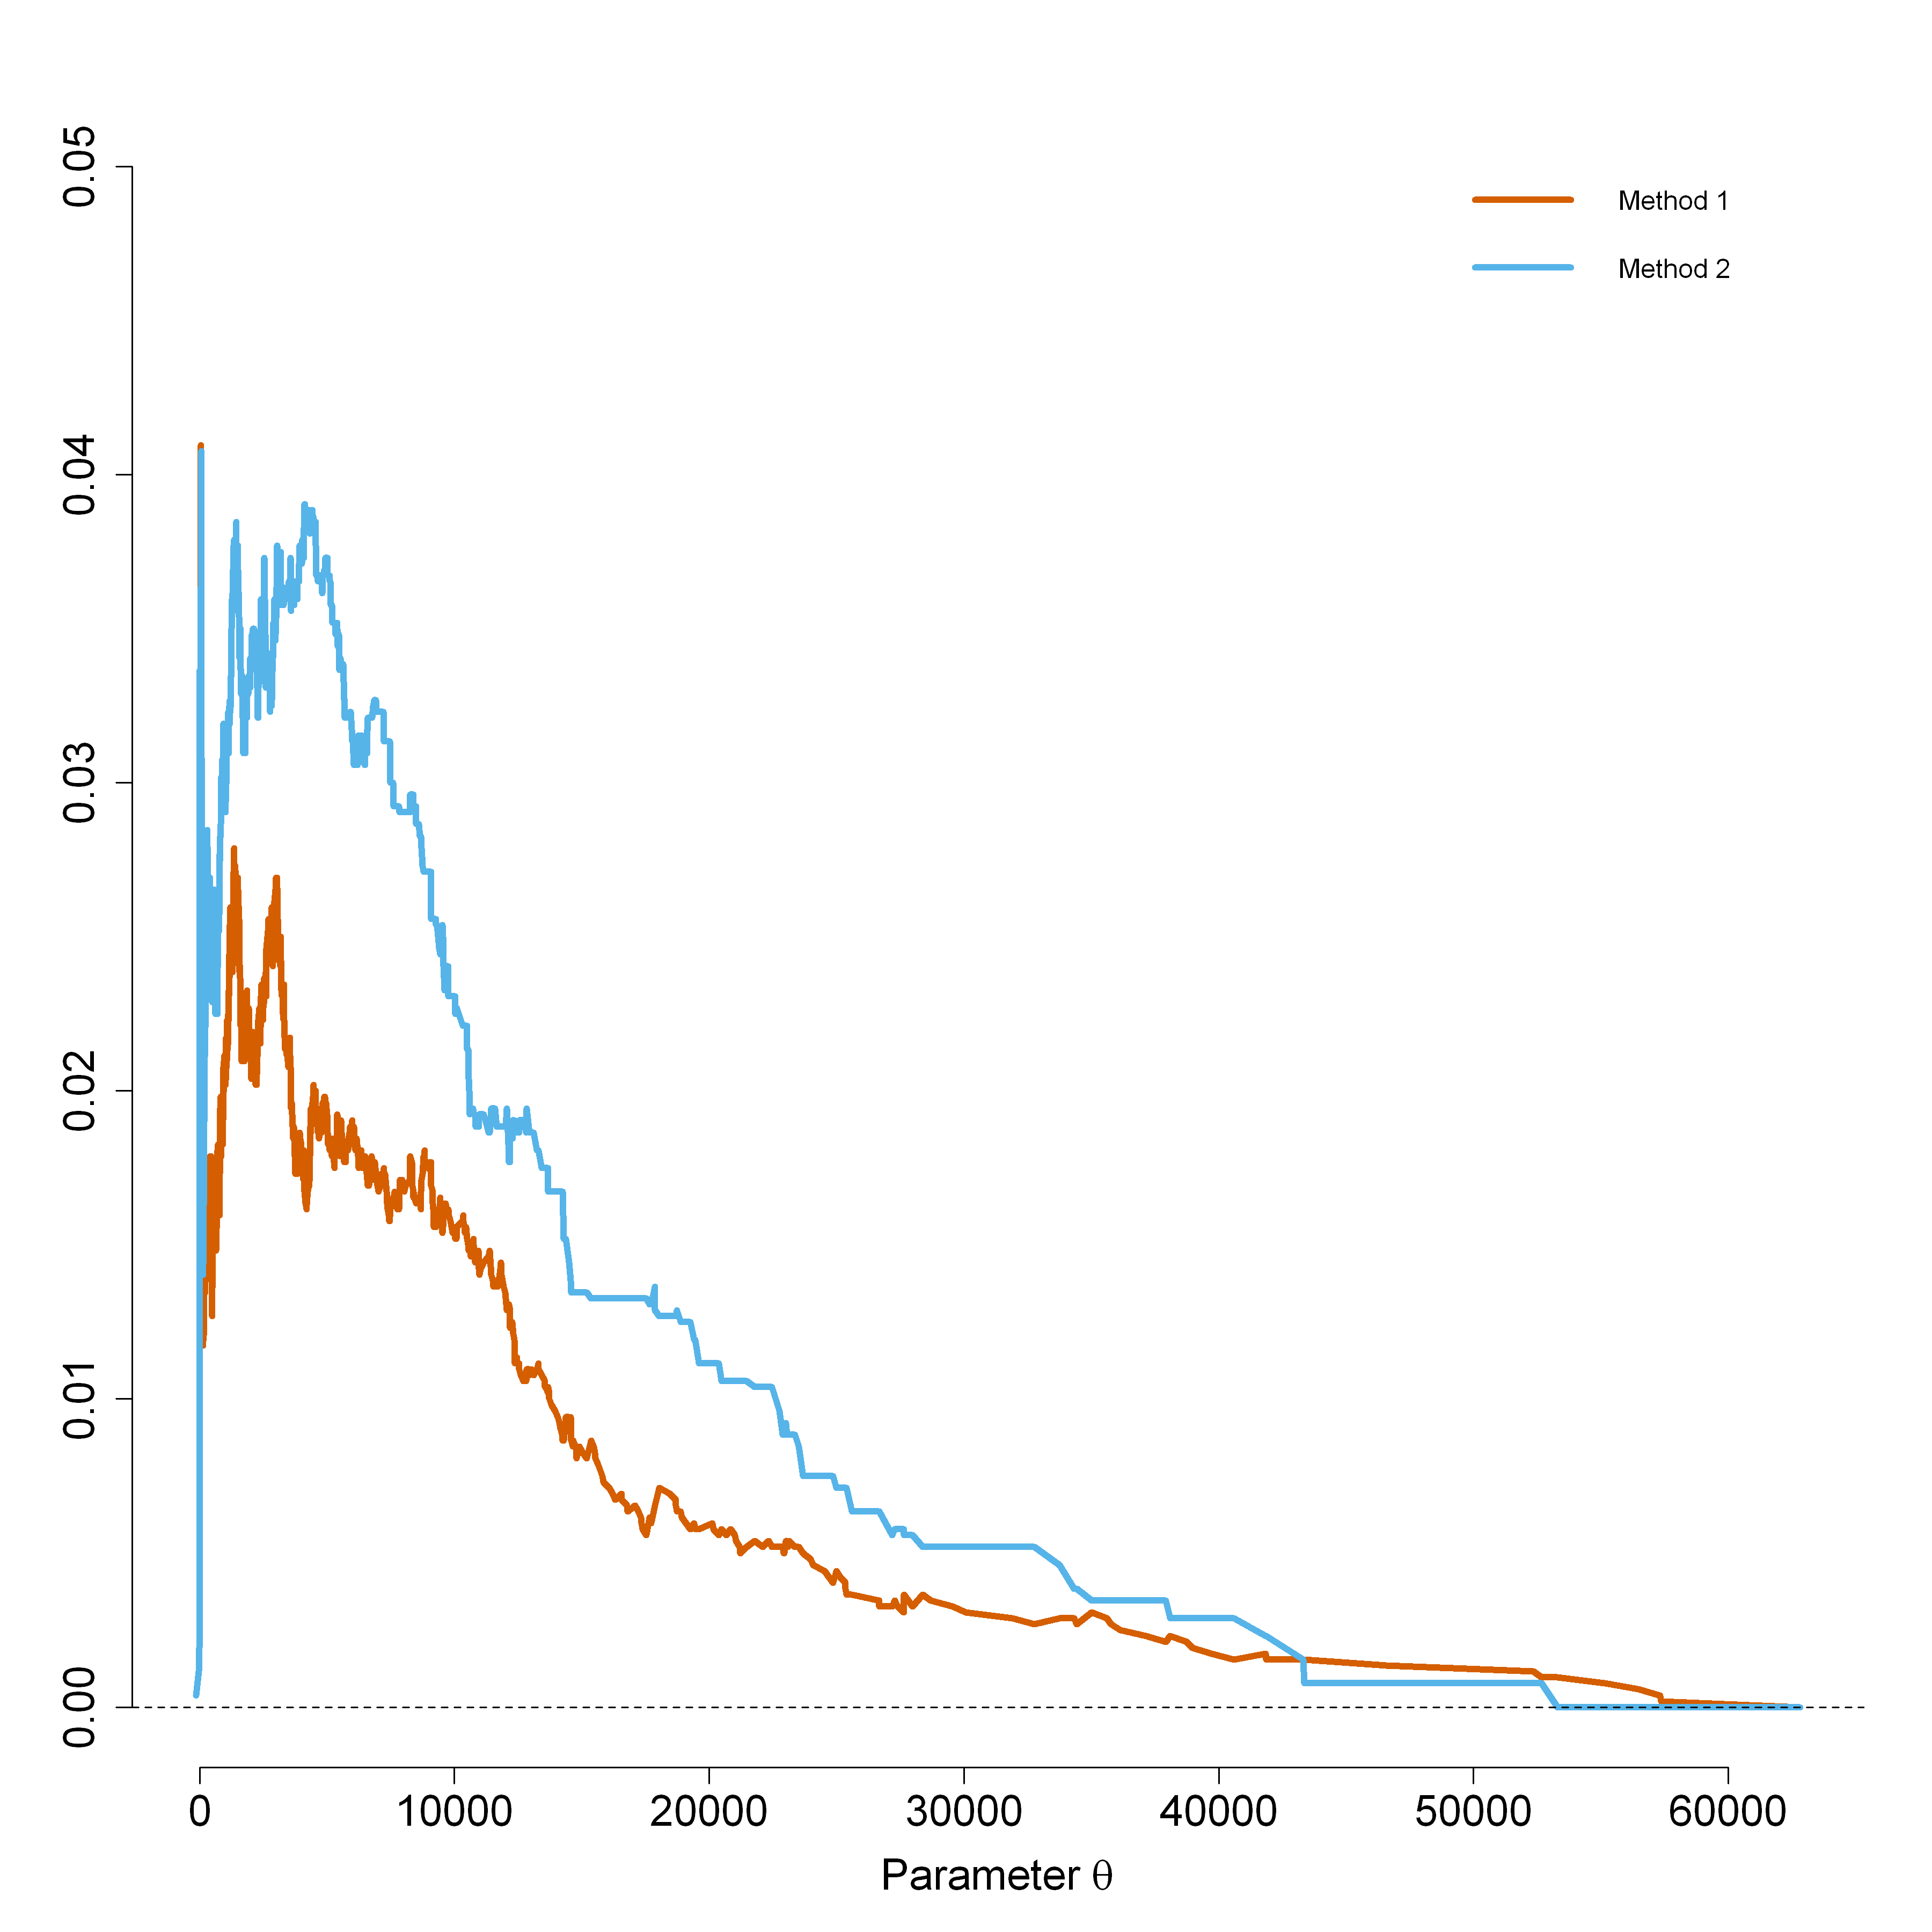

In [41]:
murphydiagram(f1, f2, y, "quantile")

In [9]:
murphy <- function(df, model1, model2, alpha = 0.5, diff = FALSE){
  
  df1 <- df %>%
    filter(quantile == alpha)
  
  f1 <- subset(df1, model == model1)$value
  f2 <- subset(df1, model == model2)$value
  y <- subset(df1, model == "COVIDhub-baseline")$truth
  
  if(diff){
    murphydiagram_diff(f1, f2, y, functional="quantile", alpha=alpha)
  }
  else{
    murphydiagram(f1, f2, y, functional="quantile", alpha=alpha, labels=c(model1, model2))
  }
}


murphy_all <- function(df, model1, model2, diff = FALSE){
  par(mfrow=c(4, 2))
  colors <- c("#D55E00", "#56B4E9", "#000000")
  qs = c(0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975)
  
  for(alpha in qs){
    df1 <- df %>%
     filter(quantile == alpha)
  
    f1 <- subset(df1, model == model1)$value
    f2 <- subset(df1, model == model2)$value
    y <- subset(df1, model == "COVIDhub-baseline")$truth
    
    outer = TRUE
    line = -2
    cex = 2
    adj  = 0.025
    
    
    if(diff){
      murphydiagram_diff(f1, f2, y, functional="quantile", alpha=alpha)
    }
    else{
      murphydiagram(f1, f2, y, functional="quantile", alpha=alpha, labels=c(model1, model2))
      #legend("right", labels = c(model1, model2), col = colors, lwd = 4, bty = "n", horiz = FALSE, cex = 1.2)
    }
    #title(outer=outer,adj=adj,main=alpha,cex.main=cex,col="black",font=2,line=line)
    title(main=alpha, font=2)
  }
}

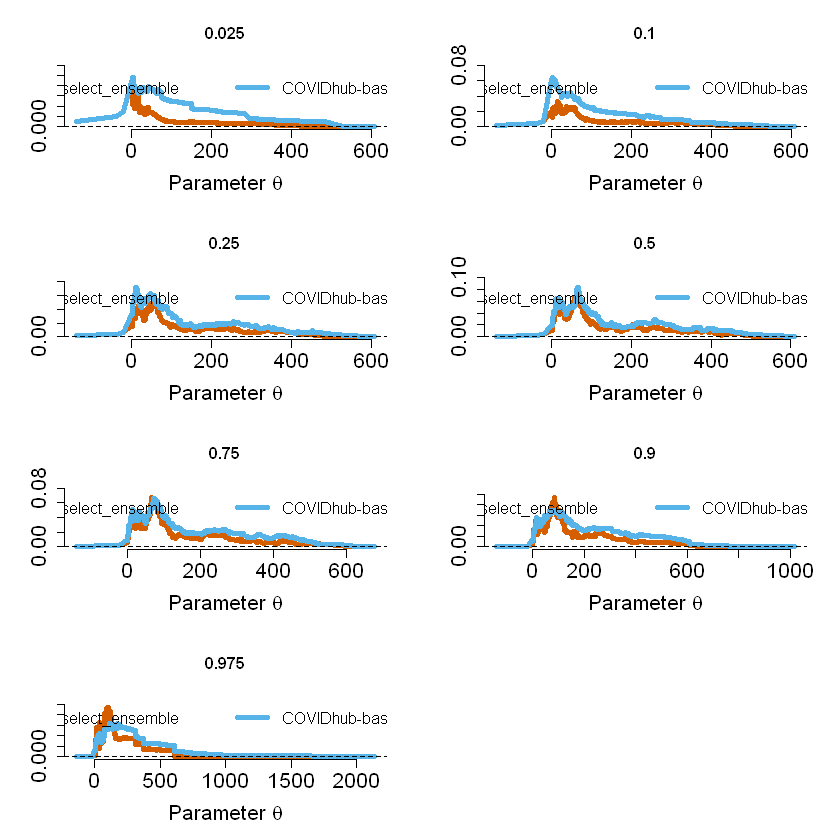

In [11]:
murphy_all(subset(df, target == "1 wk ahead inc death"), "KITmetricslab-select_ensemble", "COVIDhub-baseline")

# Reliability Diagrams

In [34]:
library("isotone")

In [361]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 200)

In [367]:
df <- read_csv("evaluation/2021-06-19_df_processed.csv", col_types = cols()) %>%
    filter(location != "US")

In [368]:
a <- df %>%
  filter(quantile == 0.9)

In [369]:
a <- a %>%
    filter(model == "KITmetricslab-select_ensemble" & target == "1 wk ahead inc case")

In [356]:
p <- gpava(a$truth, a$value)

data <- data.frame(x = p$z, y = p$x)

In [371]:
p <- gpava(a$truth, a$value, solver=weighted.fractile, p=0.9)

data <- data.frame(x = p$z, y = p$x)

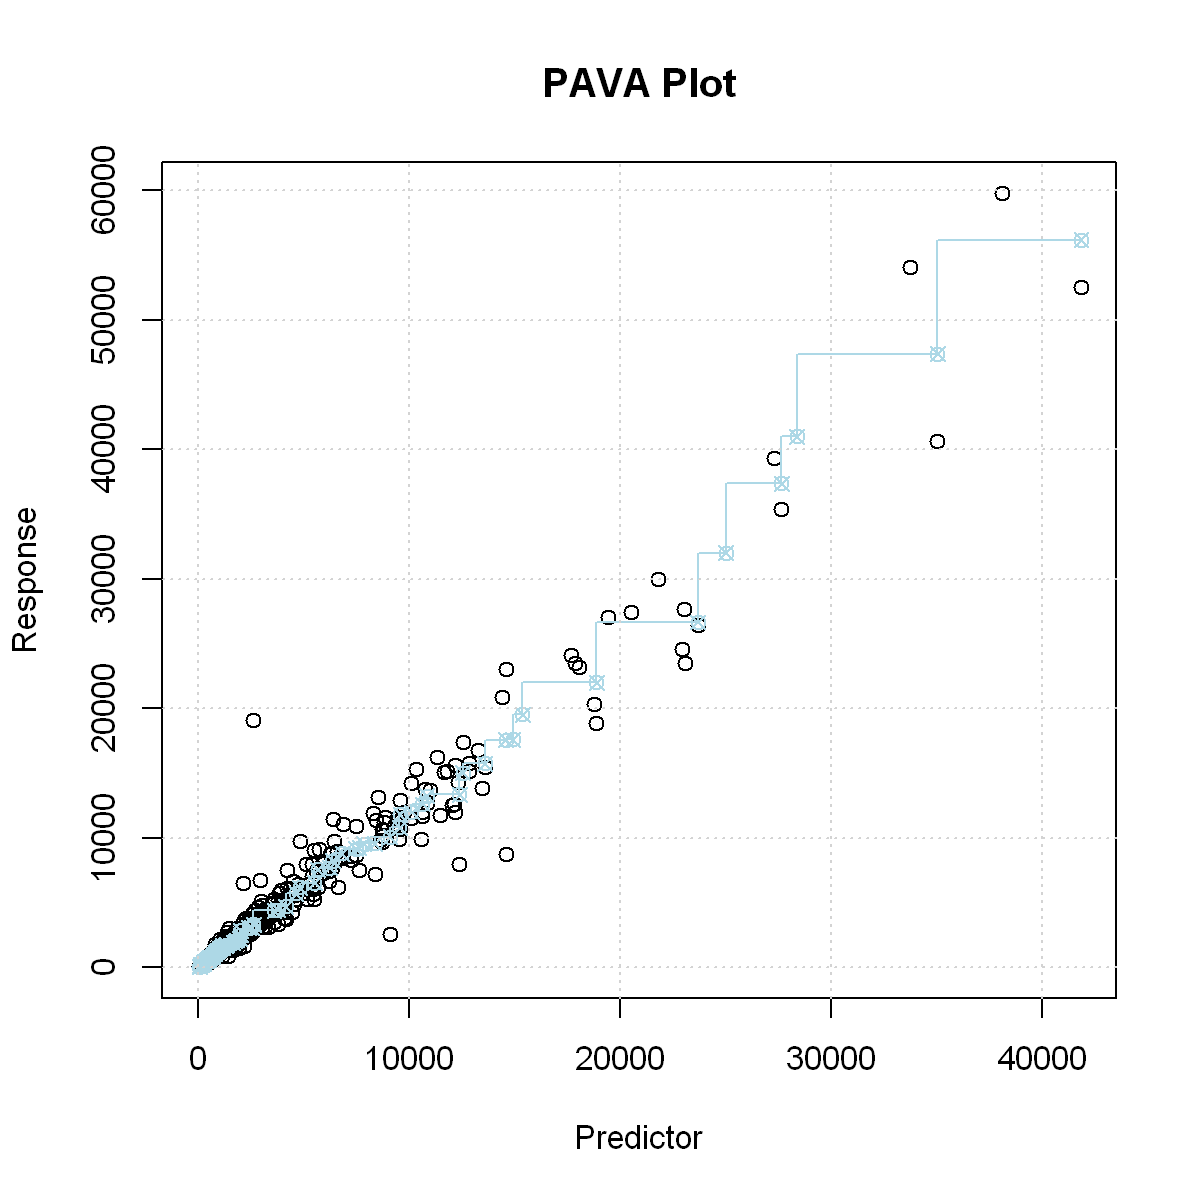

In [362]:
plot(p)

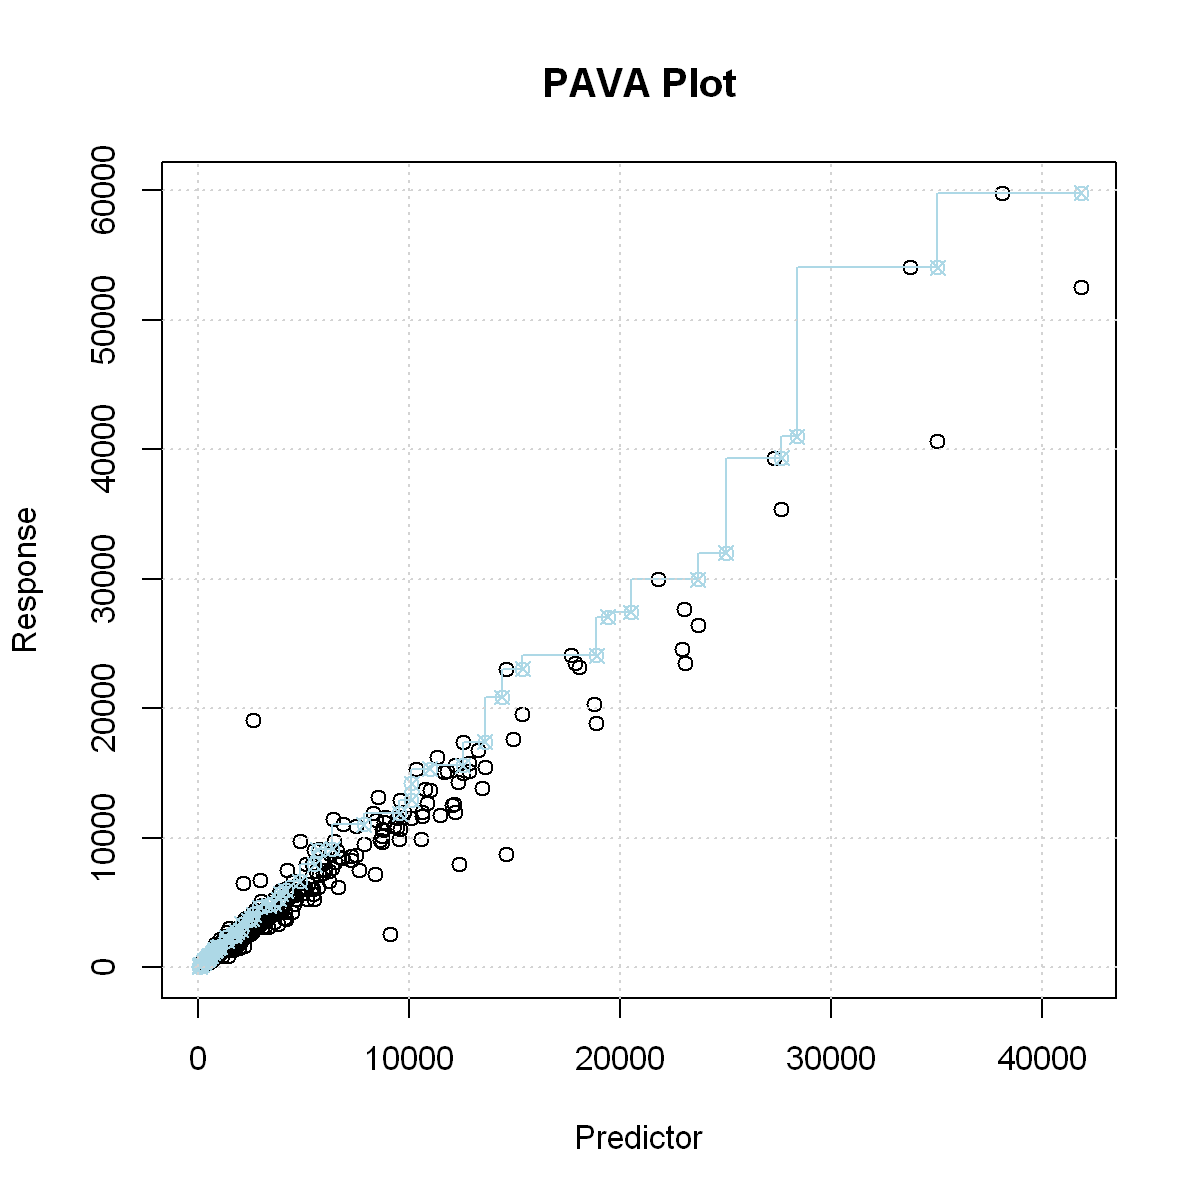

In [372]:
plot(p)

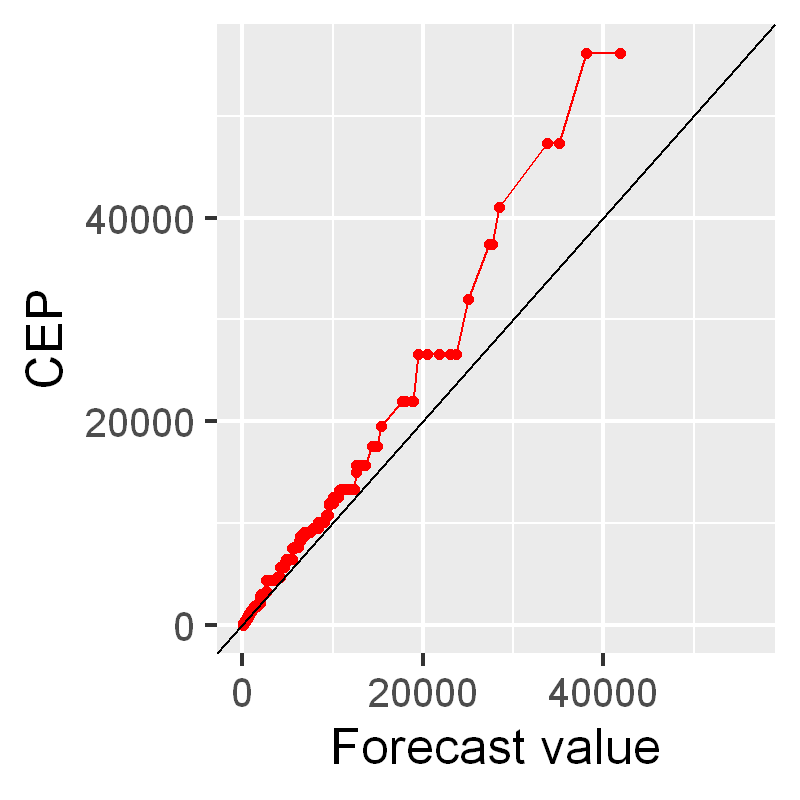

In [360]:
ggplot(data, aes(sort(x), sort(y))) +
    geom_point(color="red") +
    geom_line(color="red") +
    geom_abline(intercept =0 , slope = 1) +
    xlim(range(c(data$x, data$y))) + 
    ylim(range(c(data$x, data$y))) +
    xlab("Forecast value") +
    ylab("CEP")

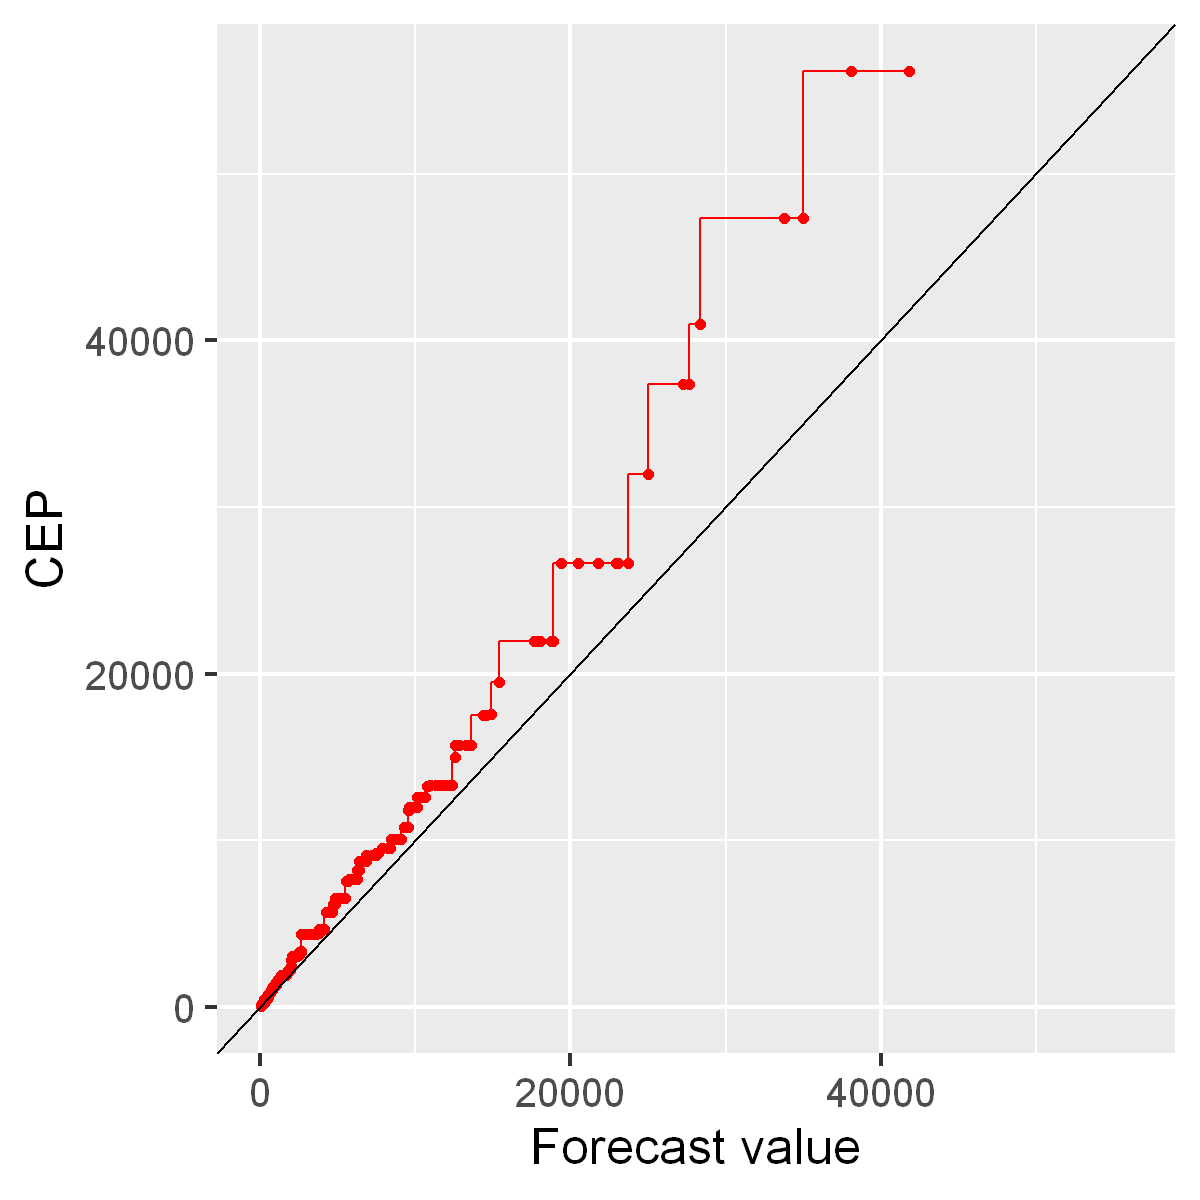

In [366]:
ggplot(data, aes(x, y)) +
    geom_point(color="red") +
    geom_step(direction="vh", color="red") +
    geom_abline(intercept =0 , slope = 1) +
    xlim(range(c(data$x, data$y))) + 
    ylim(range(c(data$x, data$y))) +
    xlab("Forecast value") +
    ylab("CEP")

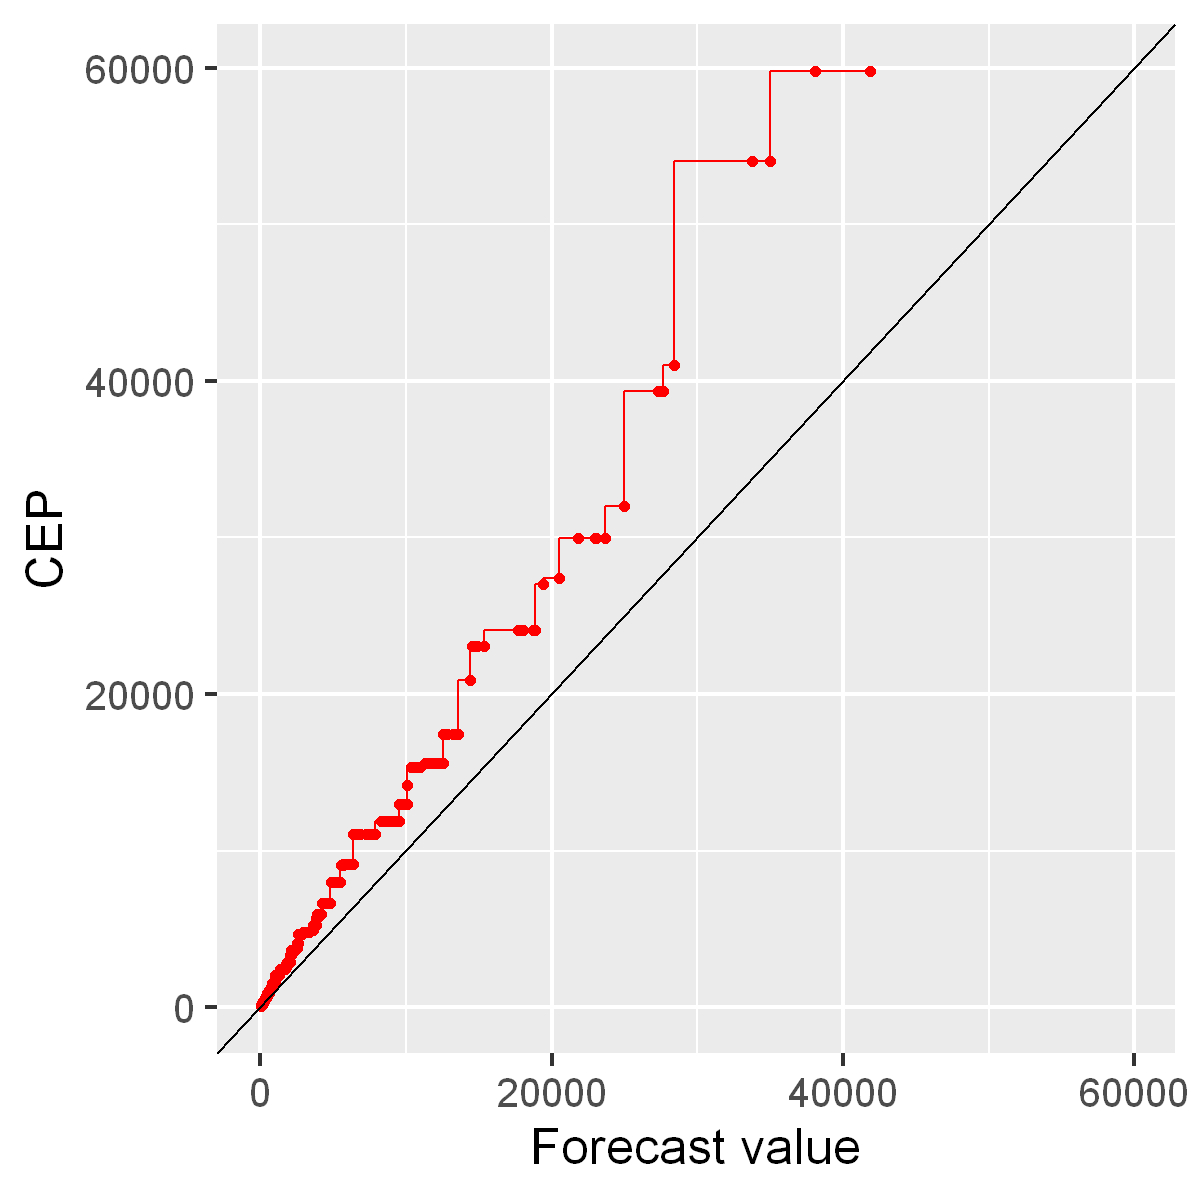

In [373]:
ggplot(data, aes(x, y)) +
    geom_point(color="red") +
    geom_step(direction="vh", color="red") +
    geom_abline(intercept =0 , slope = 1) +
    xlim(range(c(data$x, data$y))) + 
    ylim(range(c(data$x, data$y))) +
    xlab("Forecast value") +
    ylab("CEP")

In [289]:
get_recalibrated <- function(df){
    p <- gpava(df$truth, df$value)
    df <- data.frame(x = sort(p$z), y = sort(p$x))
    return(df)
}

In [300]:
reliability_diagram <- function(df, model = "COVIDhub-baseline",
                                target = "1 wk ahead inc case", 
                                quantiles = c(0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975)){
    df <- df %>%
        filter(model == !!model & target == !!target & quantile %in% quantiles)
    
    # get PAV-calibrated values
    df <- df %>%
        group_by(quantile) %>%
        do(get_recalibrated(.))
    
    # get min and max values for scaling each window
    df <- df %>%
        group_by(quantile) %>%
        mutate(ymin = min(y), xmin = min(x),
               ymax = max(y), xmax = max(x),
               mx = max(xmax, ymax),
               mn = min(xmin, ymin))
    
    options(repr.plot.width=12, repr.plot.height=4*ceiling(length(quantiles)/3), repr.plot.res = 300)
    
    ggplot(df, aes(x, y)) +
        facet_wrap("quantile", scales="free", ncol=3) +
        geom_point(color="red") +
        geom_line(color="red") +
        geom_abline(intercept = 0 , slope = 1) +
        geom_blank(aes(x = mx, y = mx)) +
        geom_blank(aes(x = mn, y = mn)) +
        xlab("Forecast value") +
        ylab("CEP") +
        labs(title = paste(model, ":", target))
}

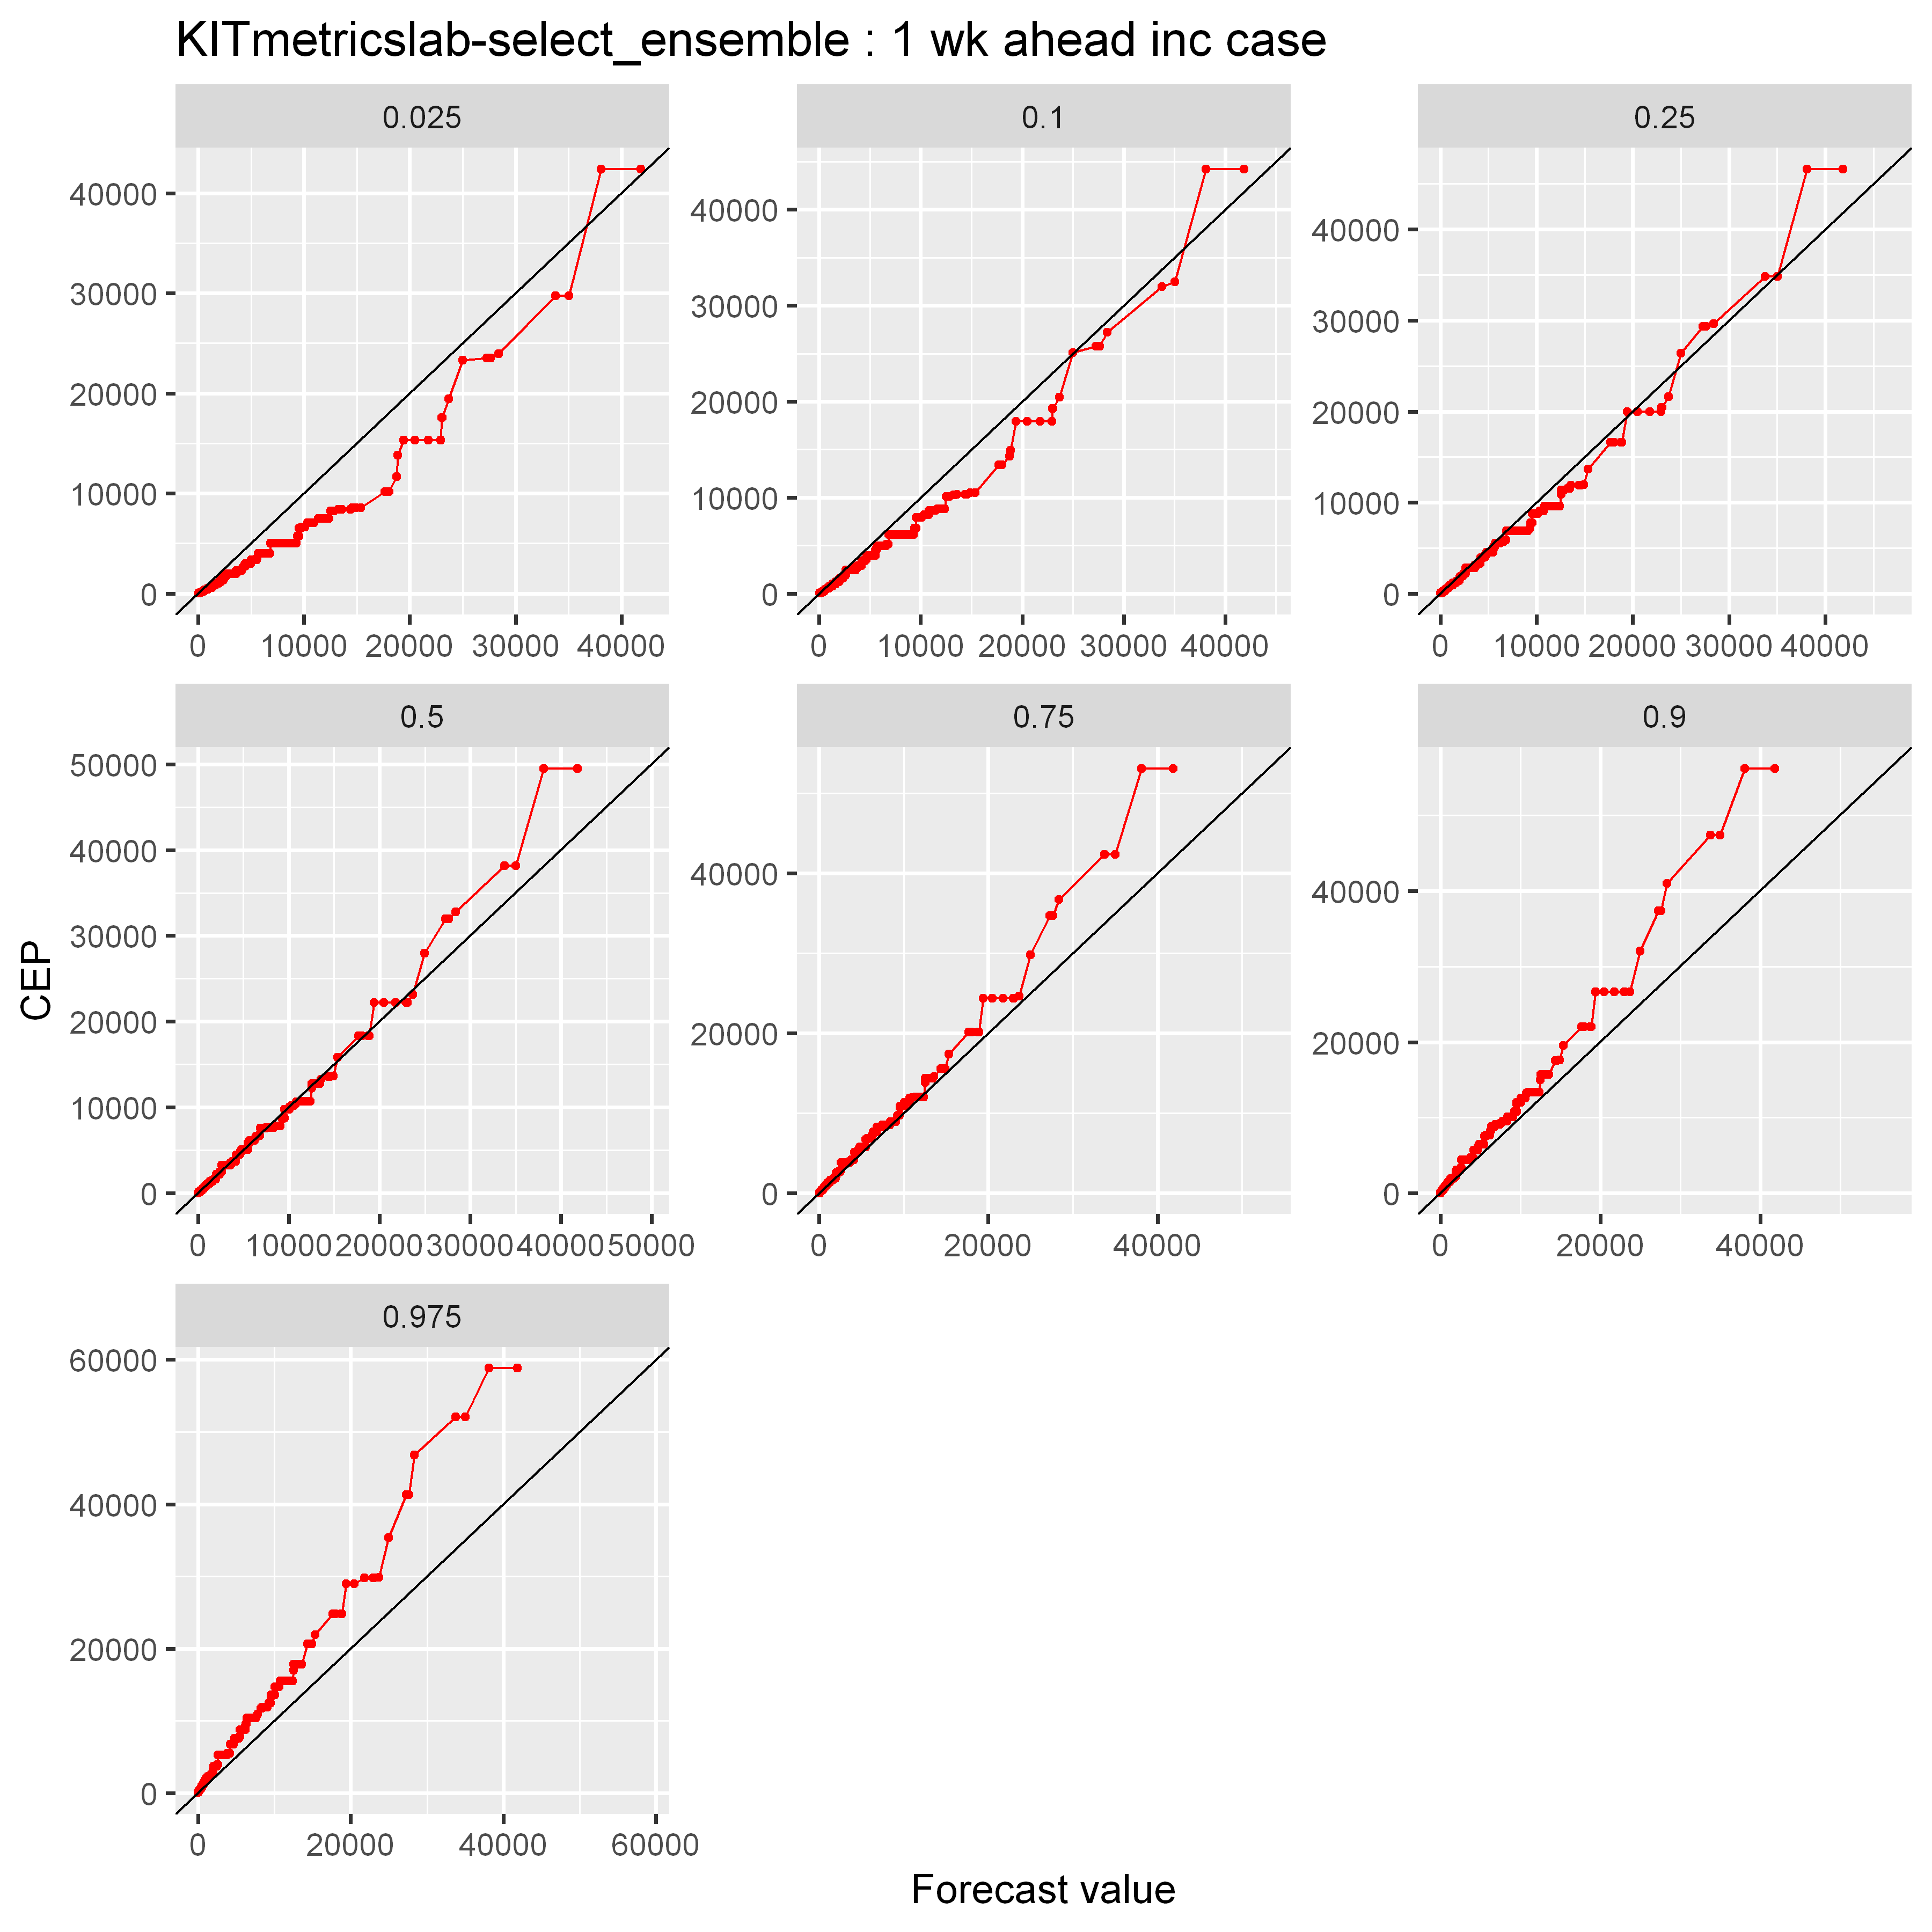

In [302]:
reliability_diagram(df, "KITmetricslab-select_ensemble", "1 wk ahead inc case")

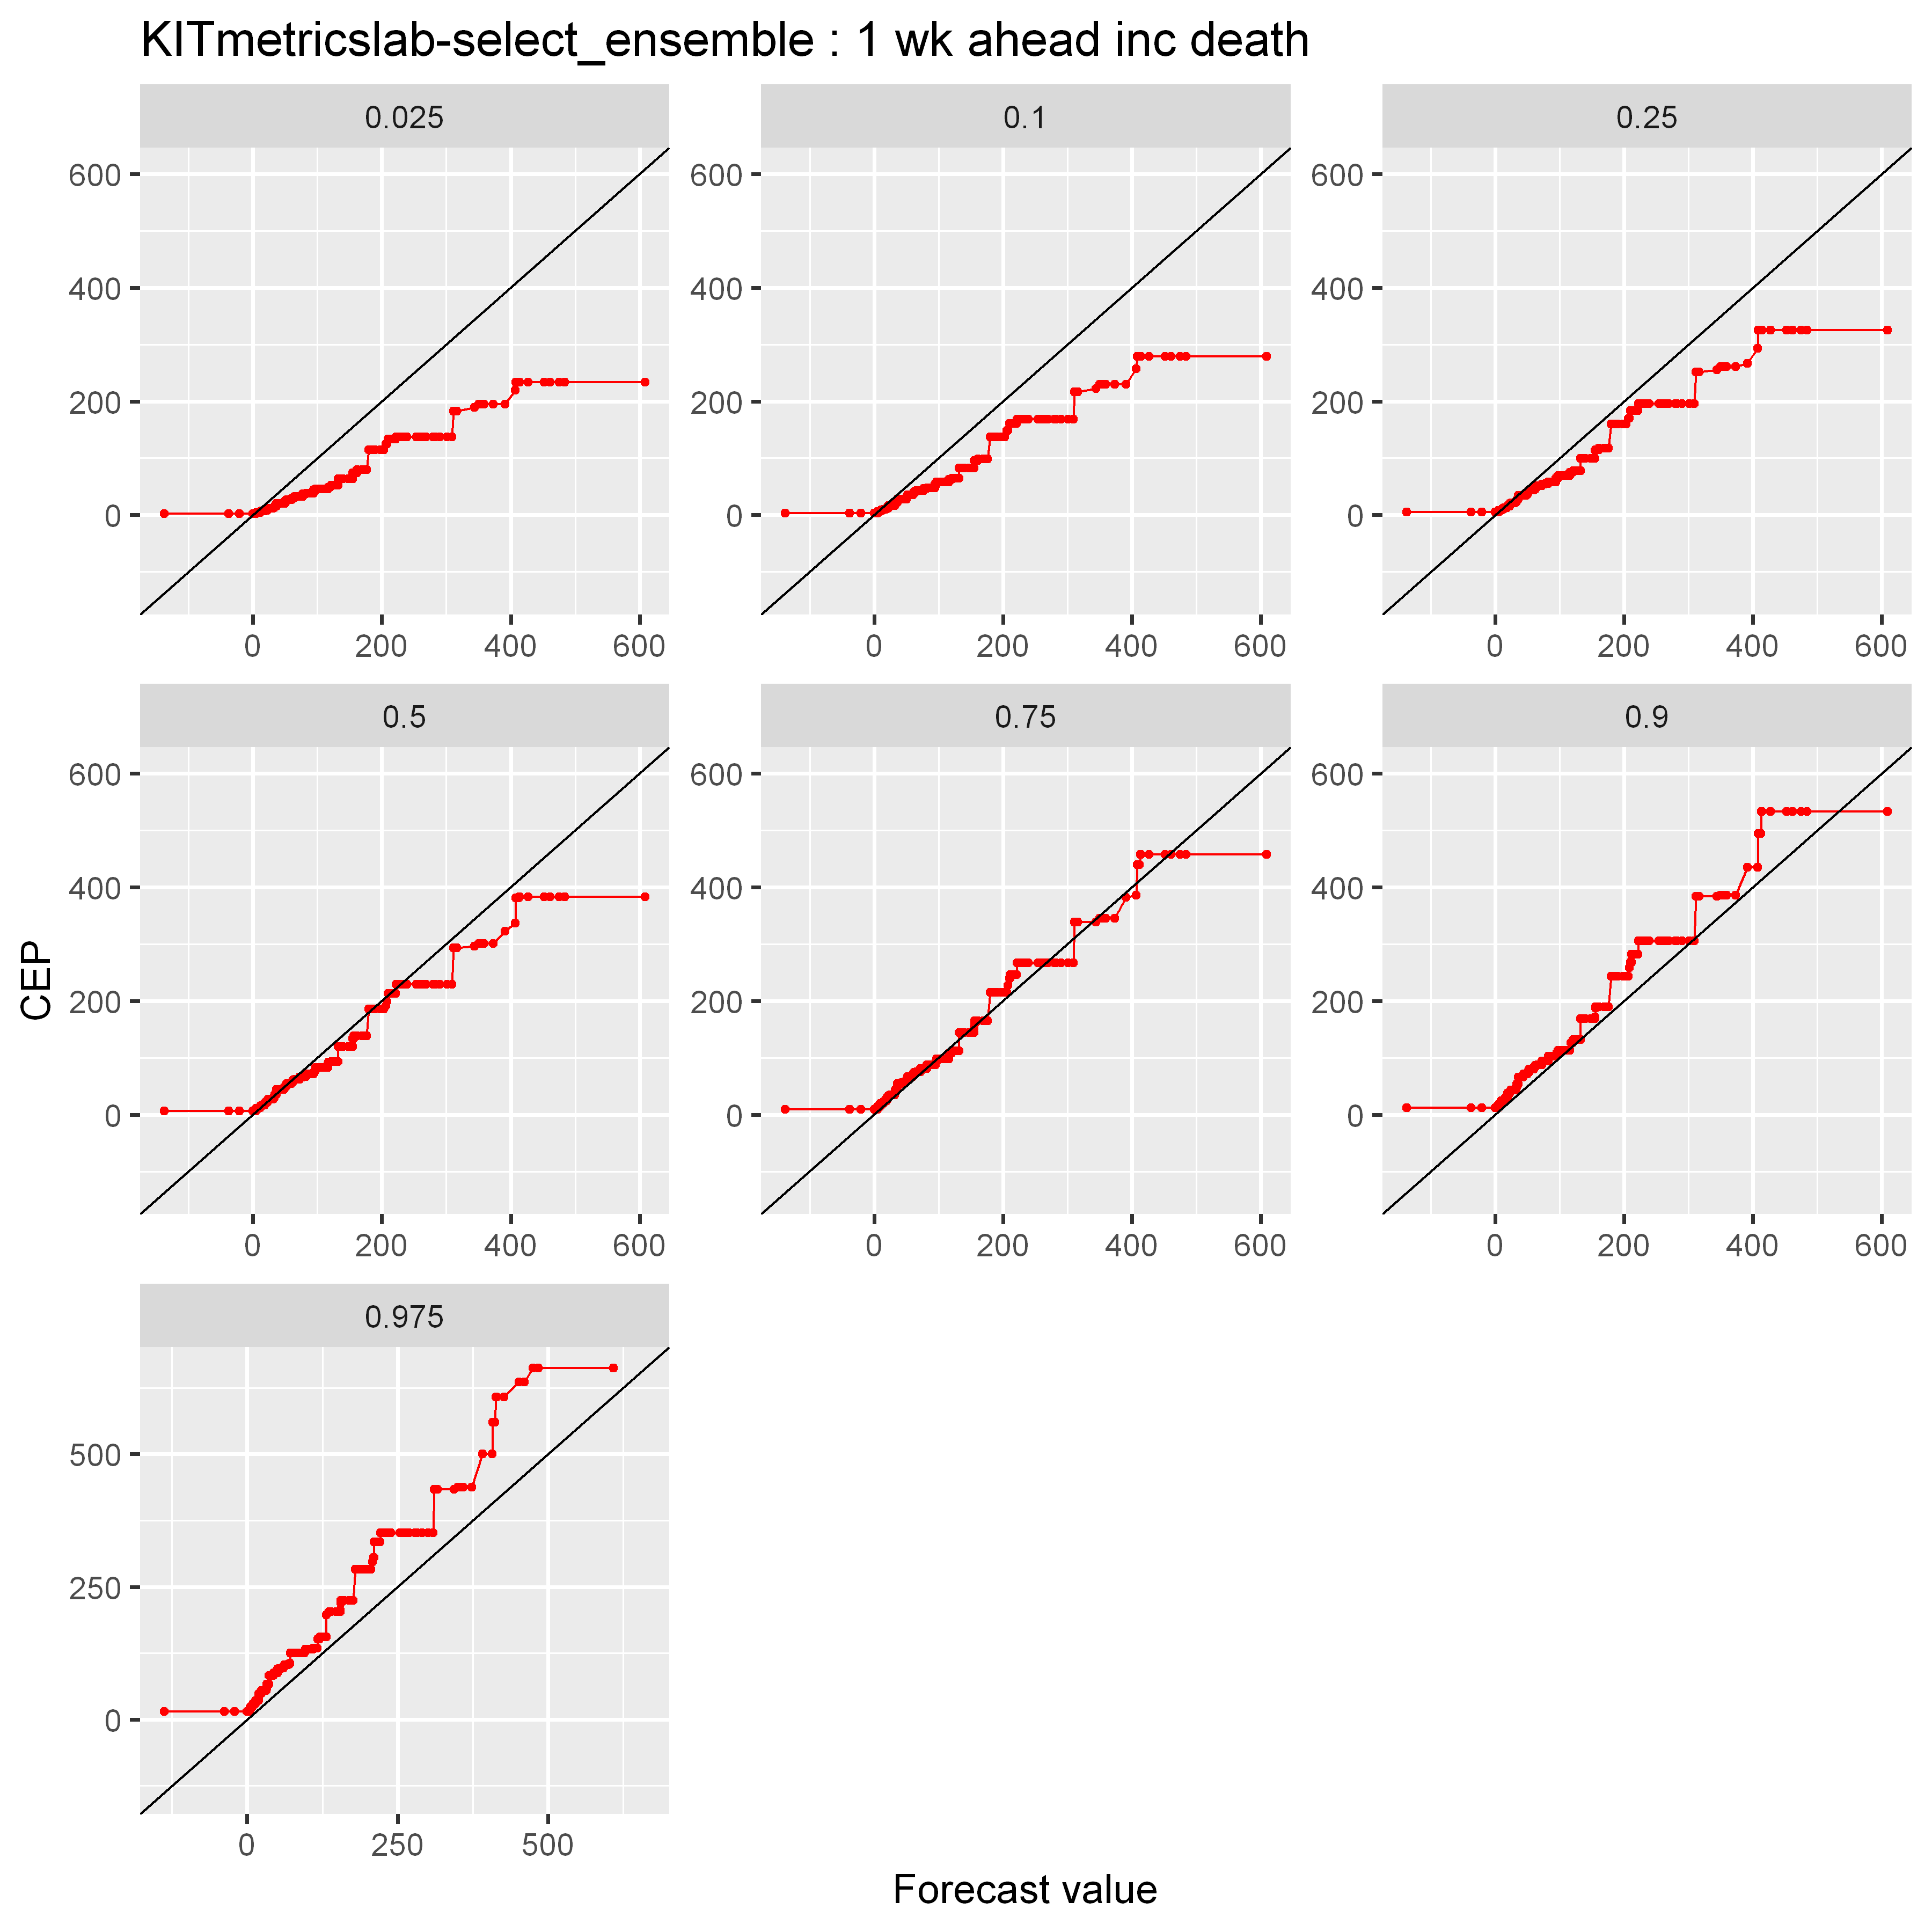

In [303]:
reliability_diagram(df, "KITmetricslab-select_ensemble", "1 wk ahead inc death")

In [193]:
dput(unique(df$quantile))

c(0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975)


In [189]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 300)

In [266]:
b <- df %>%
    group_by(quantile) %>%
    do(get_recalibrated(.))

b <- b %>%
    group_by(quantile) %>%
    mutate(ymin = min(y), xmin = min(x),
           ymax = max(y), xmax = max(x),
           mx = max(xmax, ymax),
           mn = min(xmin, ymin))

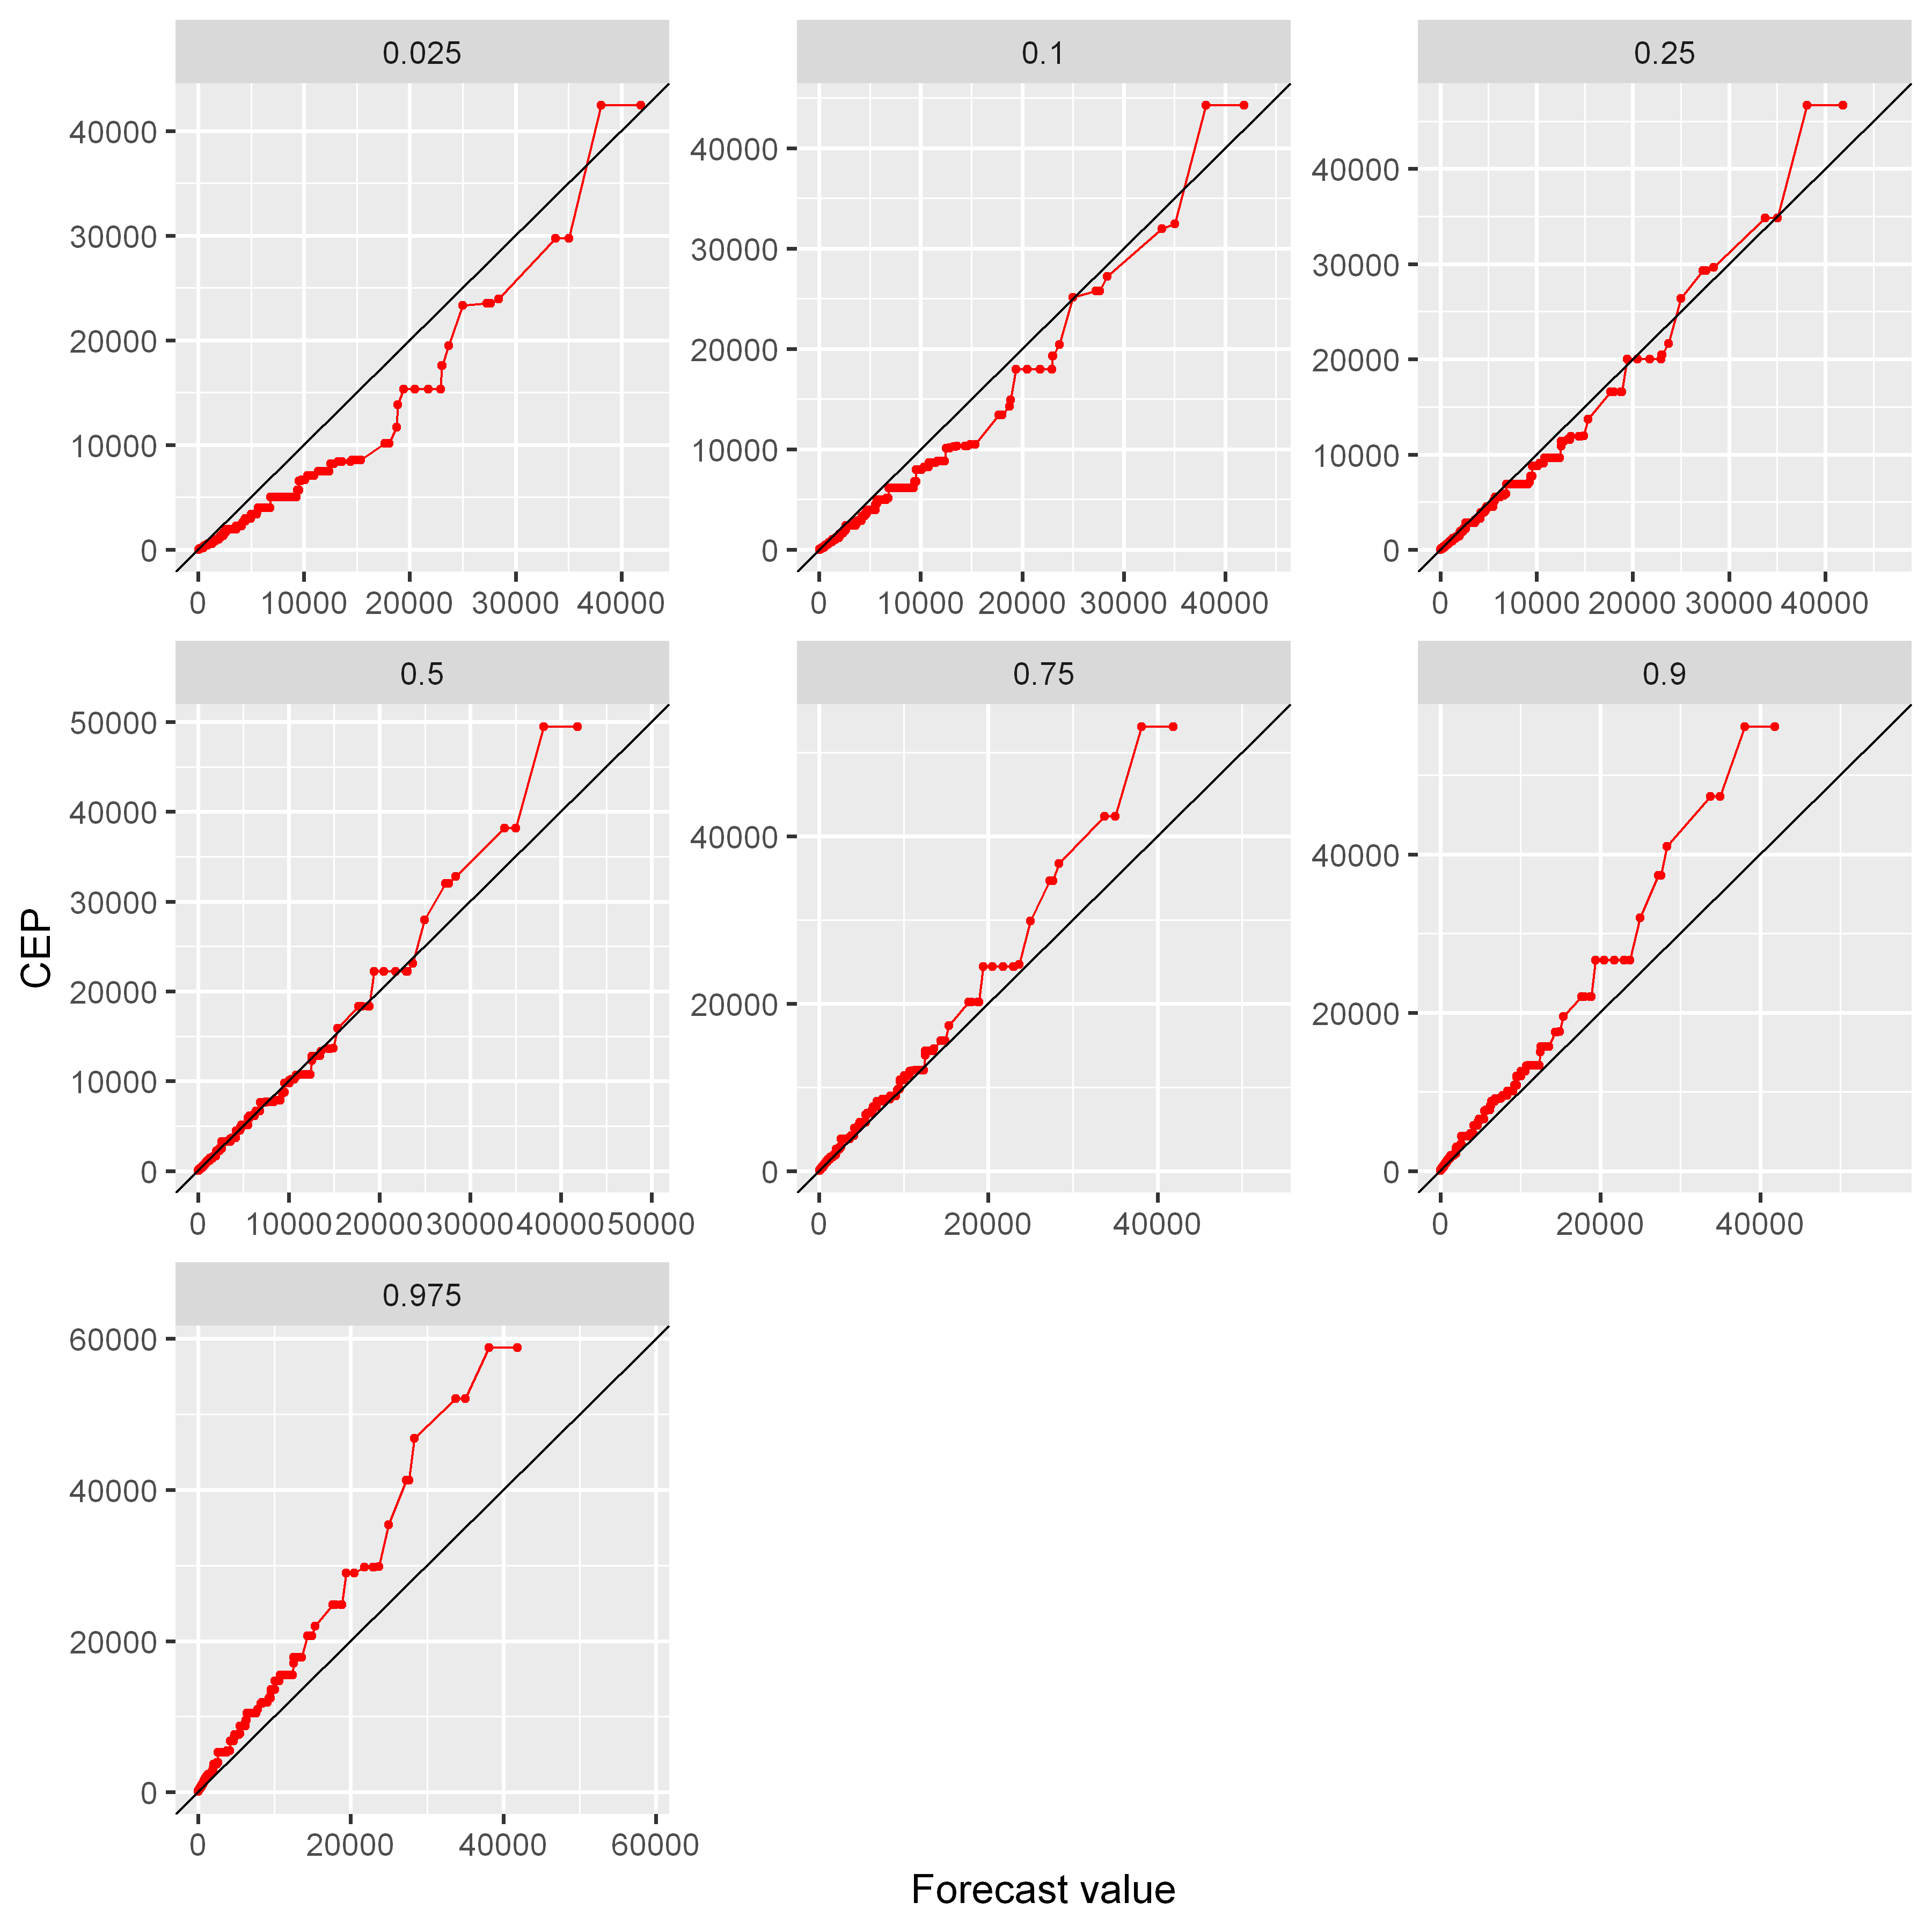

In [267]:
ggplot(b, aes(x, y)) +
    facet_wrap("quantile", scales="free", ncol=3) +
    geom_point(color="red") +
    geom_line(color="red") +
    geom_abline(intercept =0 , slope = 1) +
    geom_blank(aes(x = mx, y = mx)) +
    geom_blank(aes(x = mn, y = mn)) +
    xlab("Forecast value") +
    ylab("CEP")

In [320]:
reliability_diagram_all <- function(df, model = "COVIDhub-baseline",
                                target = "case", 
                                quantiles = c(0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975)){
    df <- df %>%
        filter(model == !!model & str_detect(target, !!target) & quantile %in% quantiles)
    
    # get PAV-calibrated values
    df <- df %>%
        group_by(target, quantile) %>%
        do(get_recalibrated(.))
    
    # get min and max values for scaling each window
    df <- df %>%
        group_by(target, quantile) %>%
        mutate(ymin = min(y), xmin = min(x),
               ymax = max(y), xmax = max(x),
               mx = max(xmax, ymax),
               mn = min(xmin, ymin))
    
    options(repr.plot.width=12, repr.plot.height=3*length(quantiles), repr.plot.res = 300)
    
    ggplot(df, aes(x, y)) +
        facet_wrap(quantile ~ target, scales = "free", ncol=4) +
        geom_point(color="red") +
        geom_line(color="red") +
        geom_abline(intercept =0 , slope = 1) +
        geom_blank(aes(x = mx, y = mx)) +
        geom_blank(aes(x = mn, y = mn)) +
        xlab("Forecast value") +
        ylab("CEP") +
        theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1, size=10), 
              axis.text.y=element_text(size=10), 
              strip.text.x = element_text(size =11), strip.placement = "outside",
              legend.position="top", legend.justification='left', legend.title=element_blank()) 
}

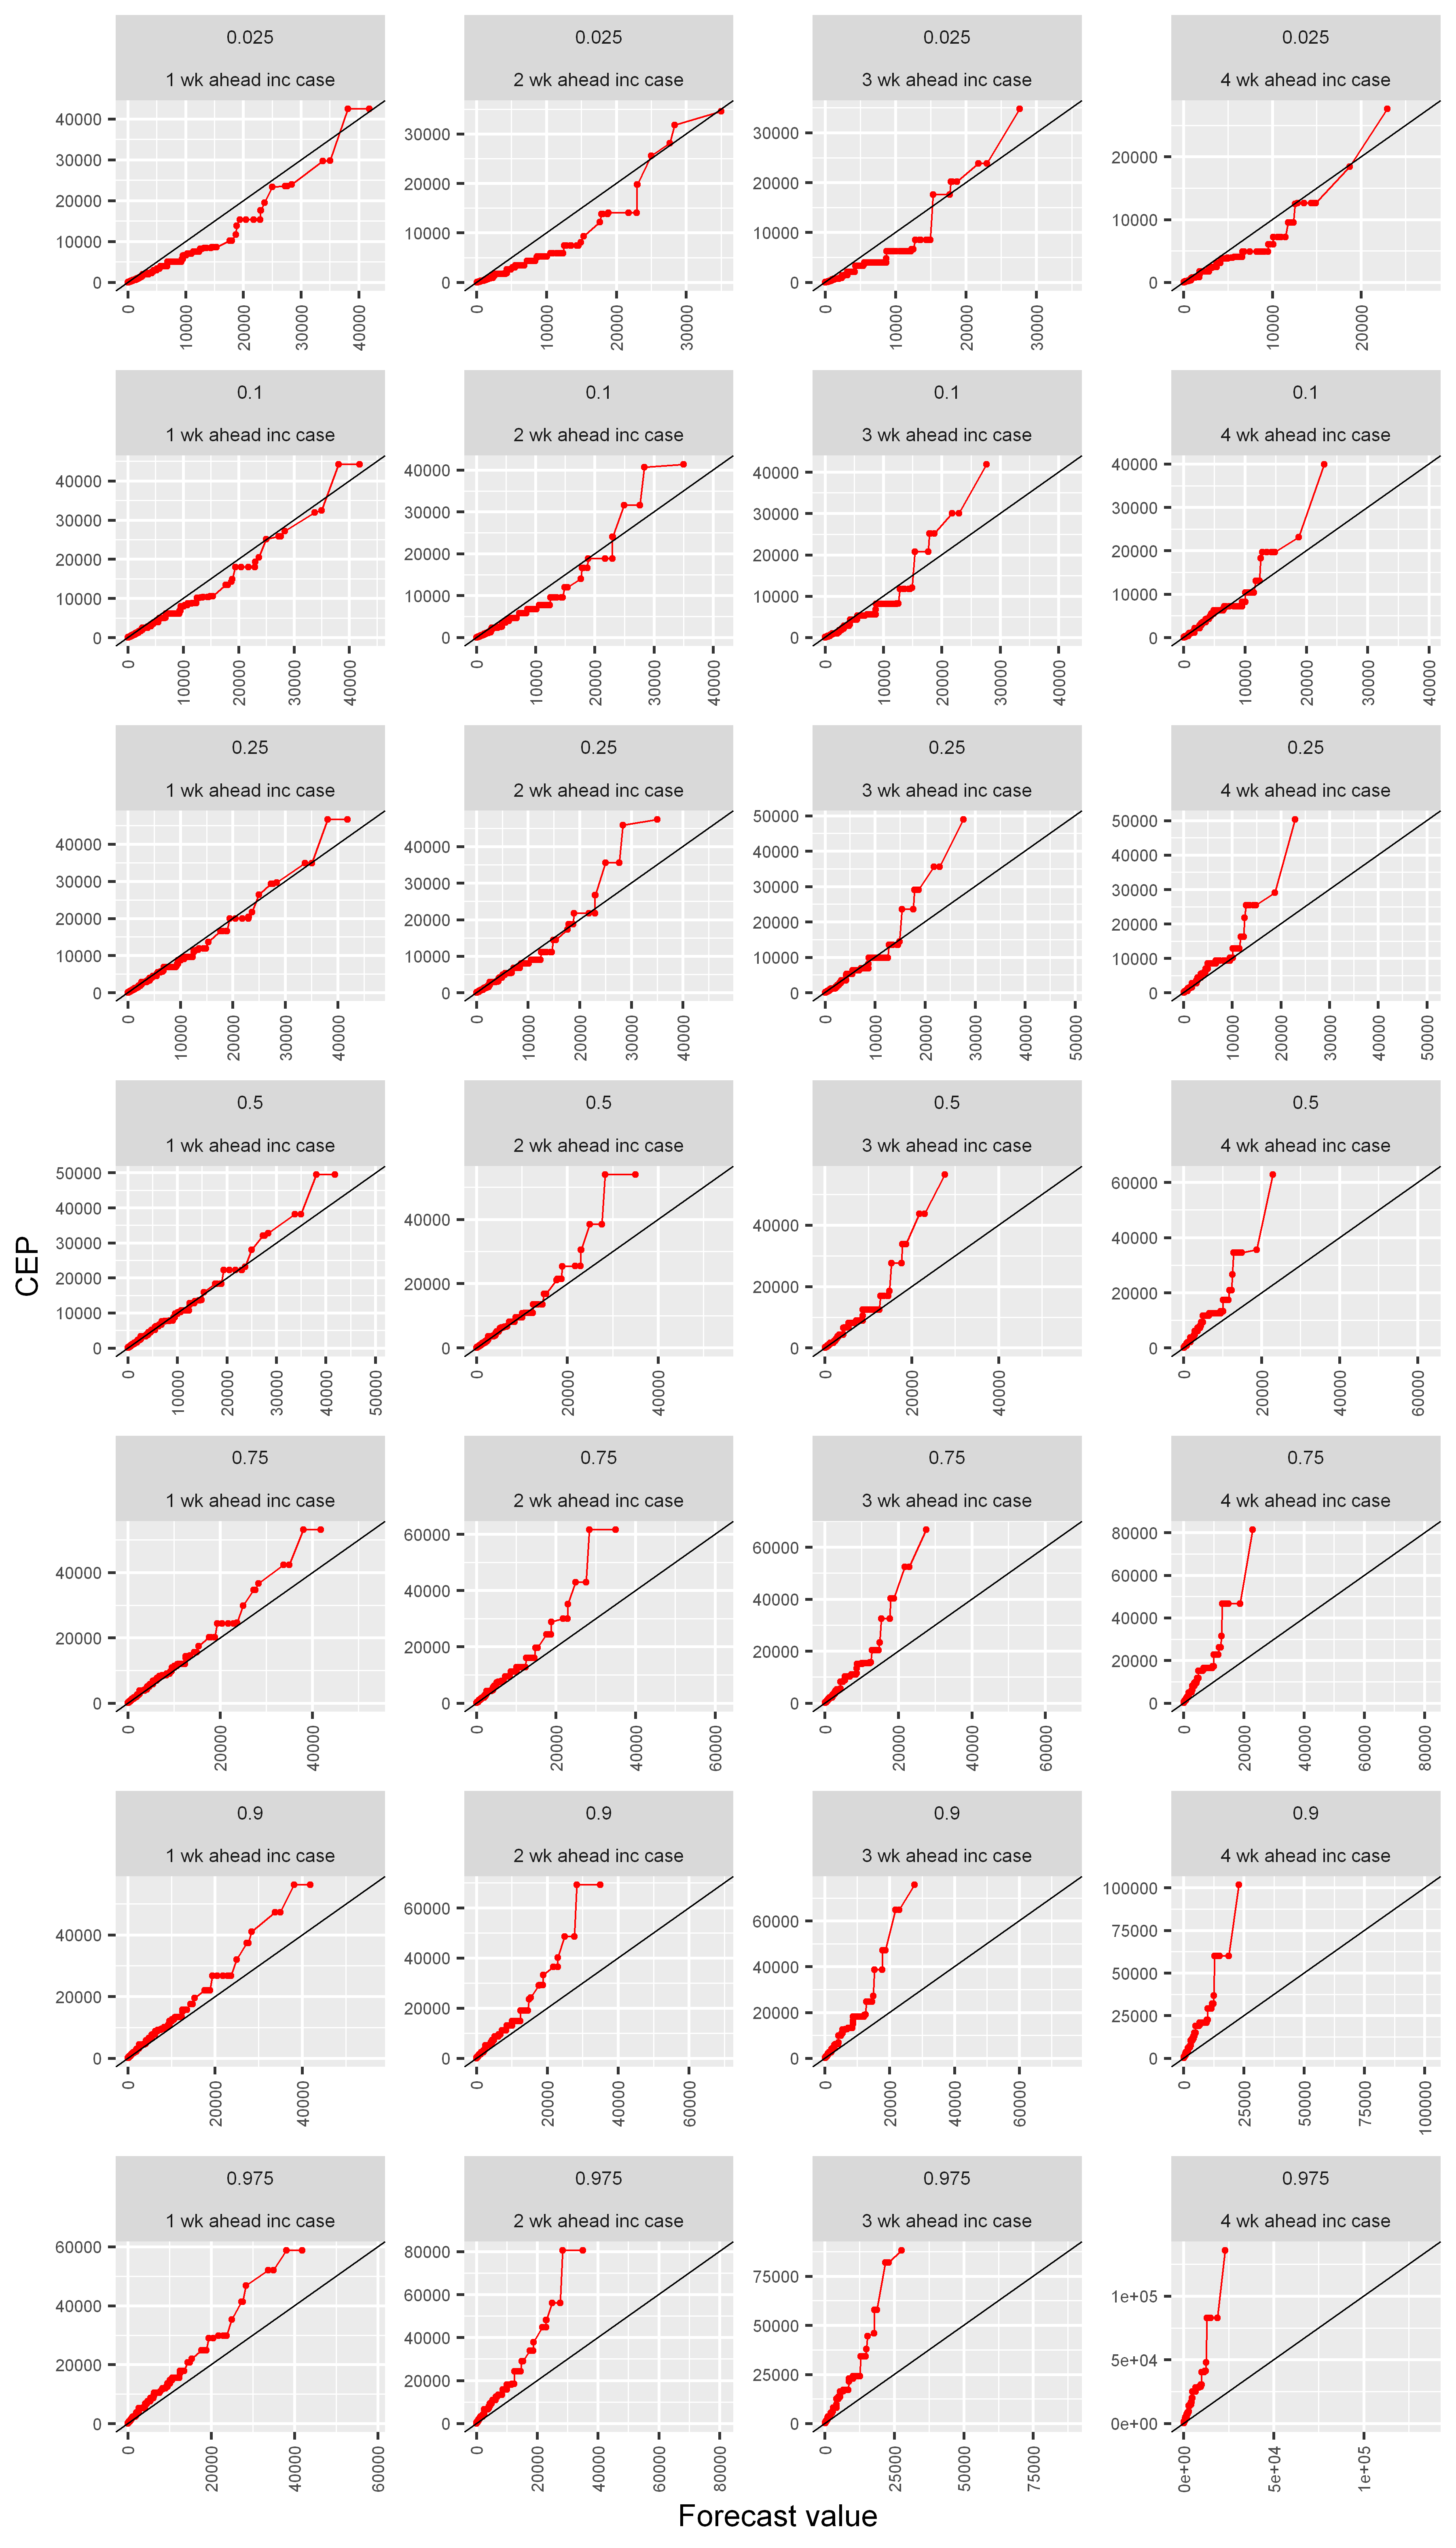

In [321]:
reliability_diagram_all(df, "KITmetricslab-select_ensemble", "case")

In [217]:
df <- df %>%
    filter(model == "KITmetricslab-select_ensemble")

df <- df %>%
    filter(str_detect(target, "case"))

b <- df %>%
    group_by(target, quantile) %>%
    do(get_recalibrated(.))

b <- b %>%
    group_by(target, quantile) %>%
    mutate(ymin = min(y), xmin = min(x),
           ymax = max(y), xmax = max(x),
           mx = max(xmax, ymax),
           mn = min(xmin, ymin))

In [248]:
options(repr.plot.width=12, repr.plot.height=24, repr.plot.res = 400)

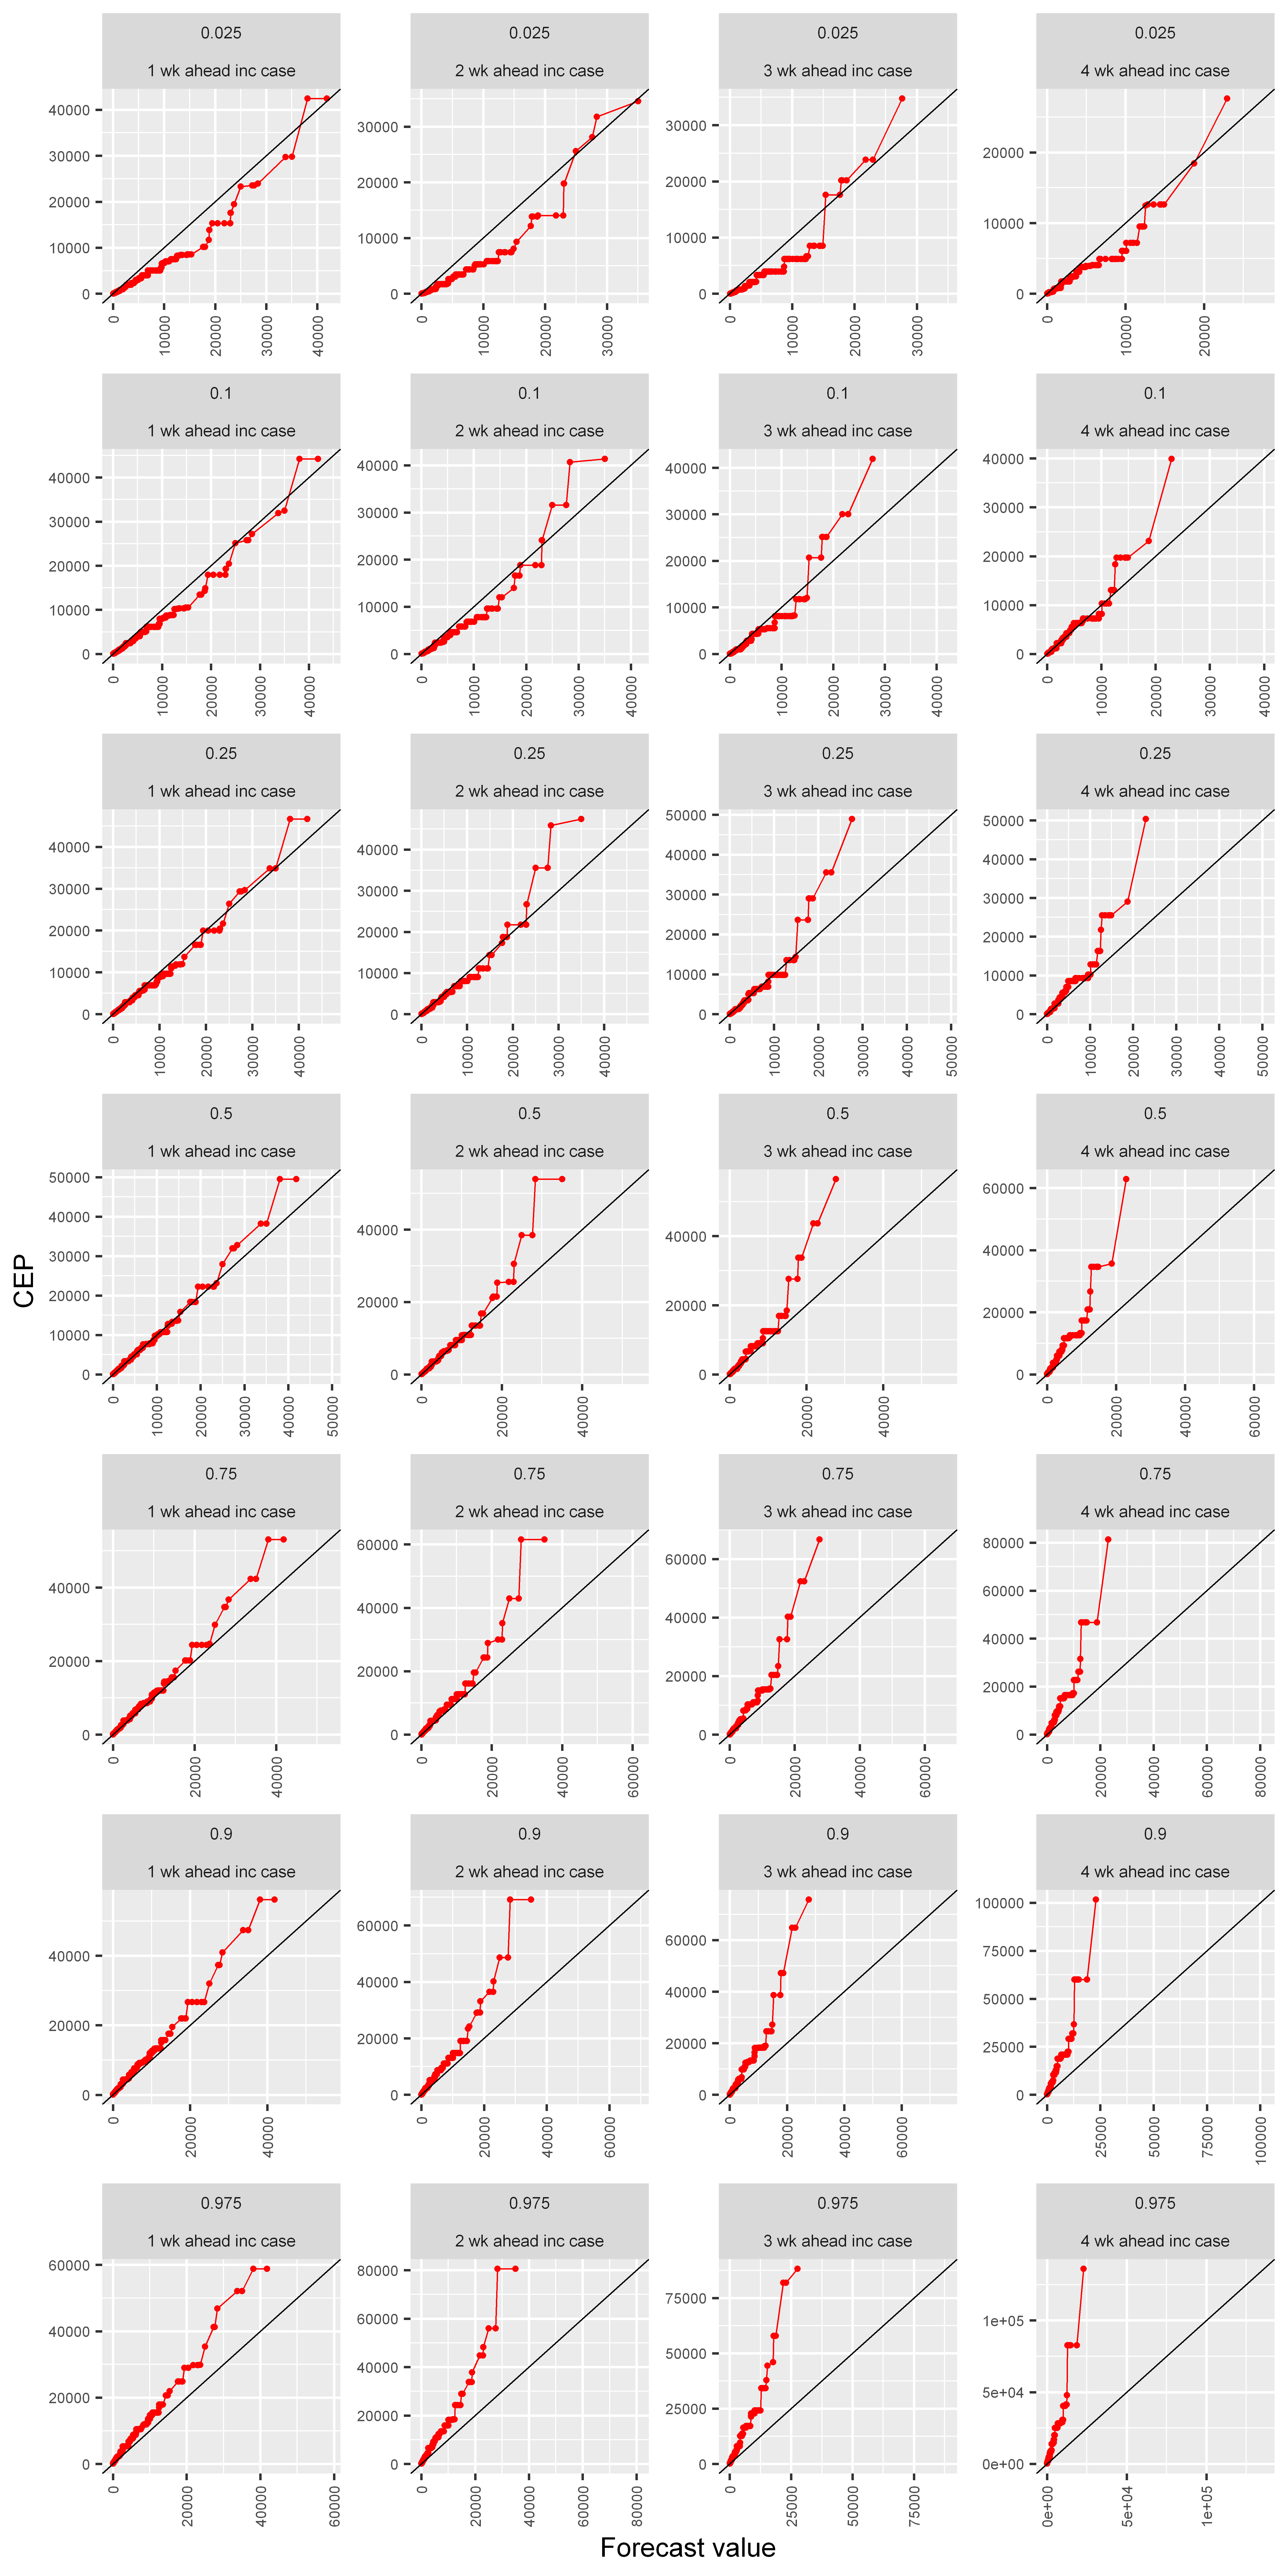

In [249]:
ggplot(b, aes(x, y)) +
    facet_wrap(quantile ~ target, scales = "free", ncol=4) +
    geom_point(color="red") +
    geom_line(color="red") +
    geom_abline(intercept =0 , slope = 1) +
    geom_blank(aes(x = mx, y = mx)) +
    geom_blank(aes(x = mn, y = mn)) +
    xlab("Forecast value") +
    ylab("CEP") +
    theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1, size=10), 
          axis.text.y=element_text(size=10), 
          strip.text.x = element_text(size =11), strip.placement = "outside",
          legend.position="top", legend.justification='left', legend.title=element_blank()) 

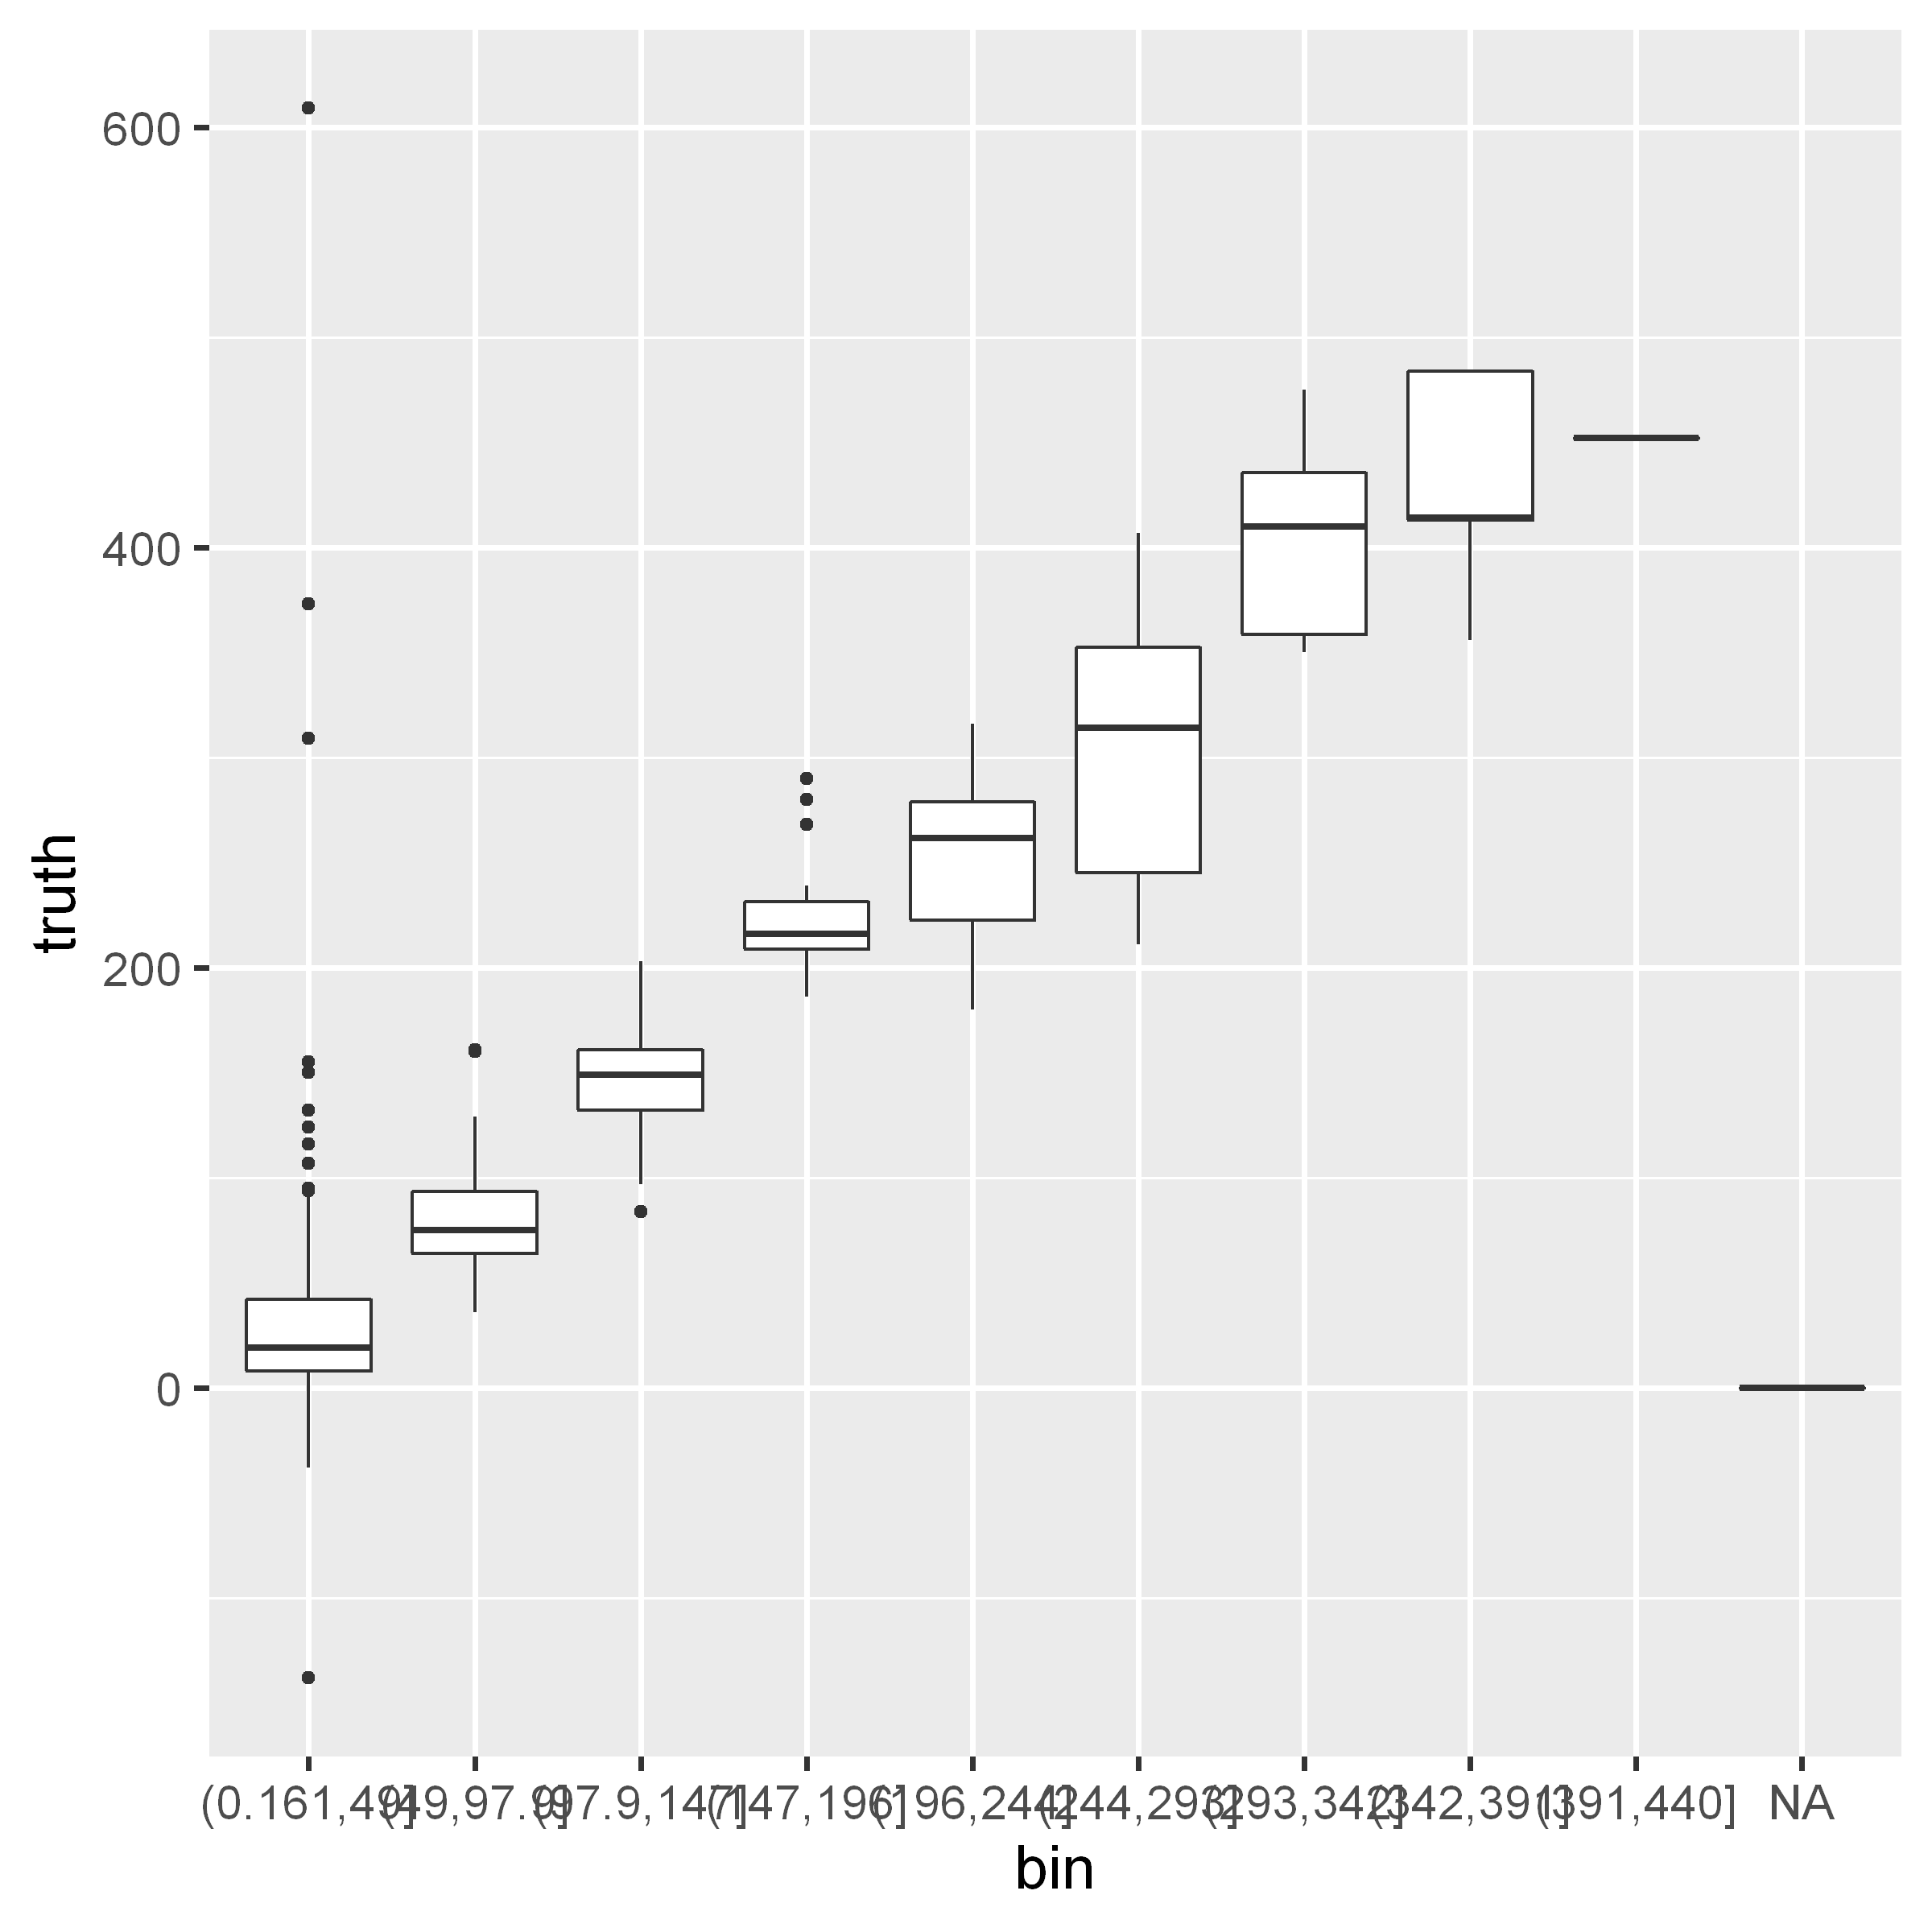

In [23]:
ggplot(a, aes(x=bin, y=truth)) +
  geom_boxplot()

# Forecasts

Shown are national level median forecasts (white dots) together with 50% and 95% prediciton intervals. The observed values are shown in black.

In [22]:
df <- read_csv("evaluation/2021-06-19_df_processed.csv", col_types = cols())
df <- pivot_wider(df, names_from=quantile, names_prefix="value.", values_from=value)

In [23]:
cols <- colorRampPalette(c("deepskyblue4", "lightgrey"))(2 + 1)[-1]

In [24]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 300)

In [25]:
df_ens <- df %>%
filter(model == "KITmetricslab-select_ensemble",
      location == "US")

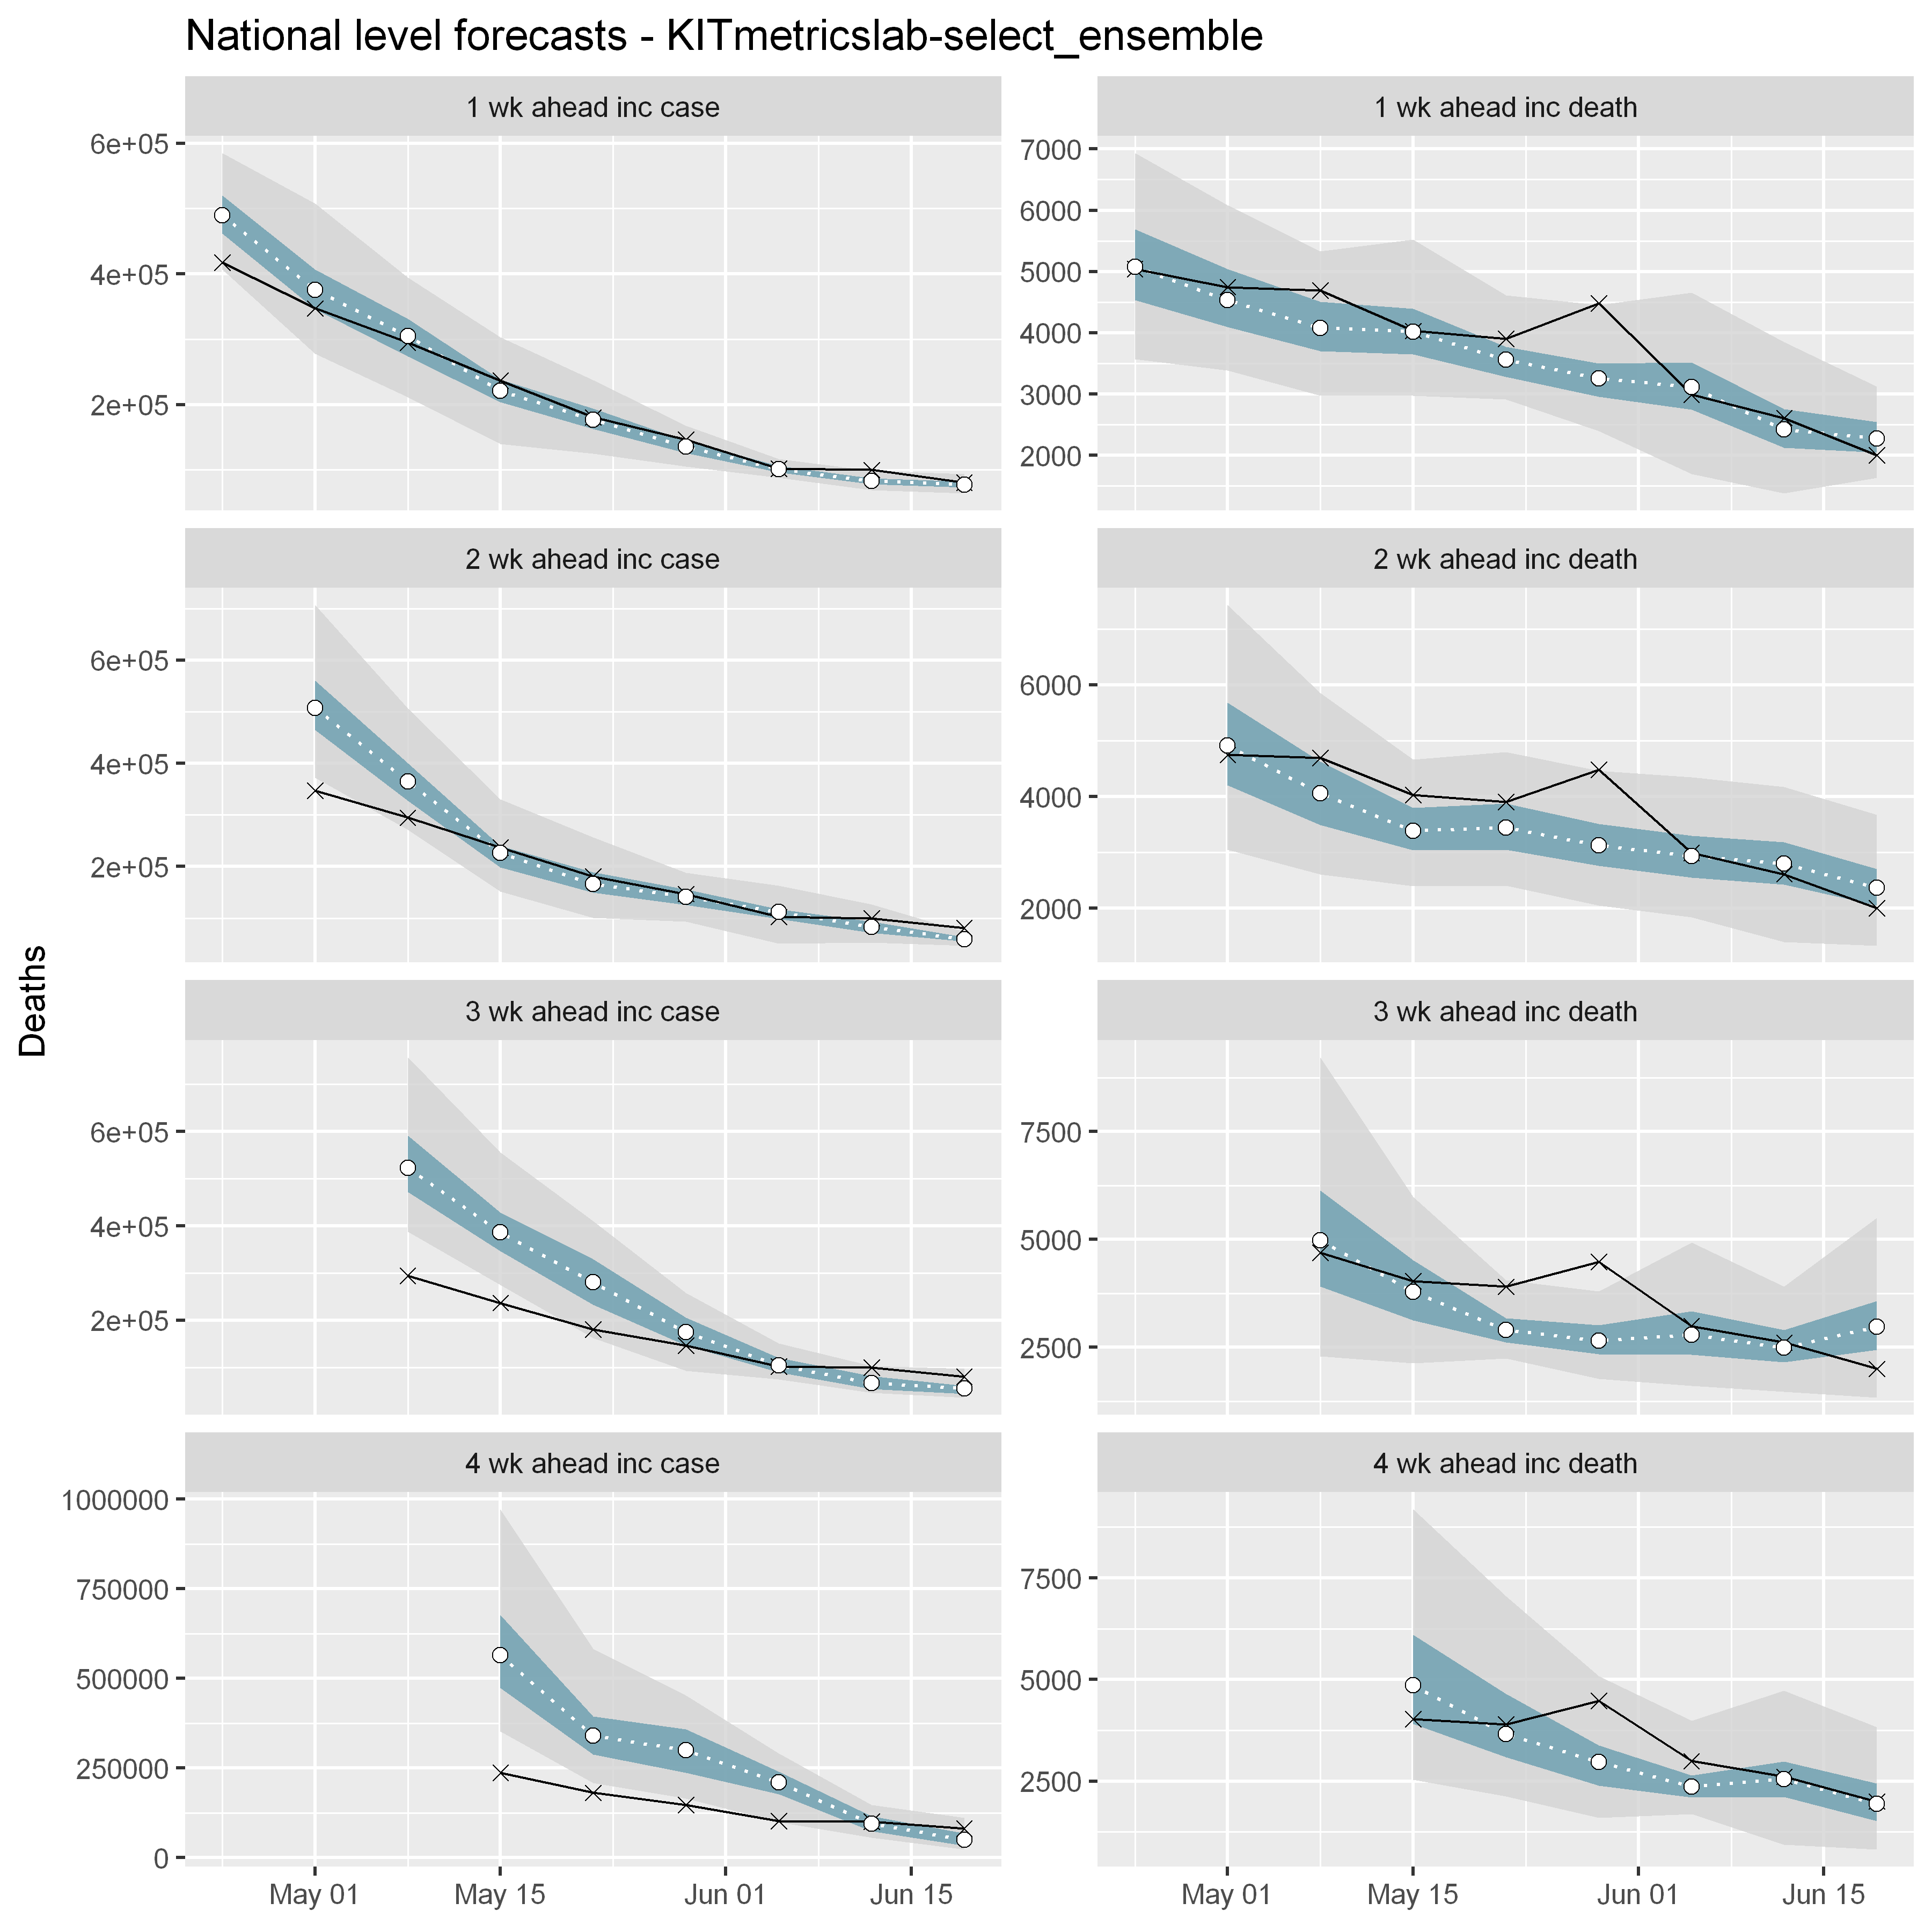

In [26]:
ggplot(df_ens, aes(x=target_end_date, y=truth)) +
  facet_wrap("target", scales="free_y", ncol=2) +
  geom_smooth(aes(y = value.0.5, ymin = value.0.025, ymax = value.0.975), 
              linetype=3, size=0.7, colour="white", fill=cols[2], alpha=0.8, stat = "identity") +
  geom_smooth(aes(y = value.0.5, ymin = value.0.25, ymax = value.0.75),
              linetype=3, size=0.7, colour="white", fill=cols[1], alpha=0.8, stat = "identity") +
  geom_line() +
  geom_point(pch = 4, size=3) +
  geom_point(aes(y = value.0.5), pch = 21, col = "black", bg = "white", size=3) +
  theme_bw() +
  labs(title="National level forecasts - KITmetricslab-select_ensemble",
       x = NULL,
       y = "Deaths") +
  theme_grey(base_size=16) +
  theme(strip.text.y = element_text(size = 8))

In [27]:
df_ens <- df %>%
filter(model == "COVIDhub-ensemble",
      location == "US")

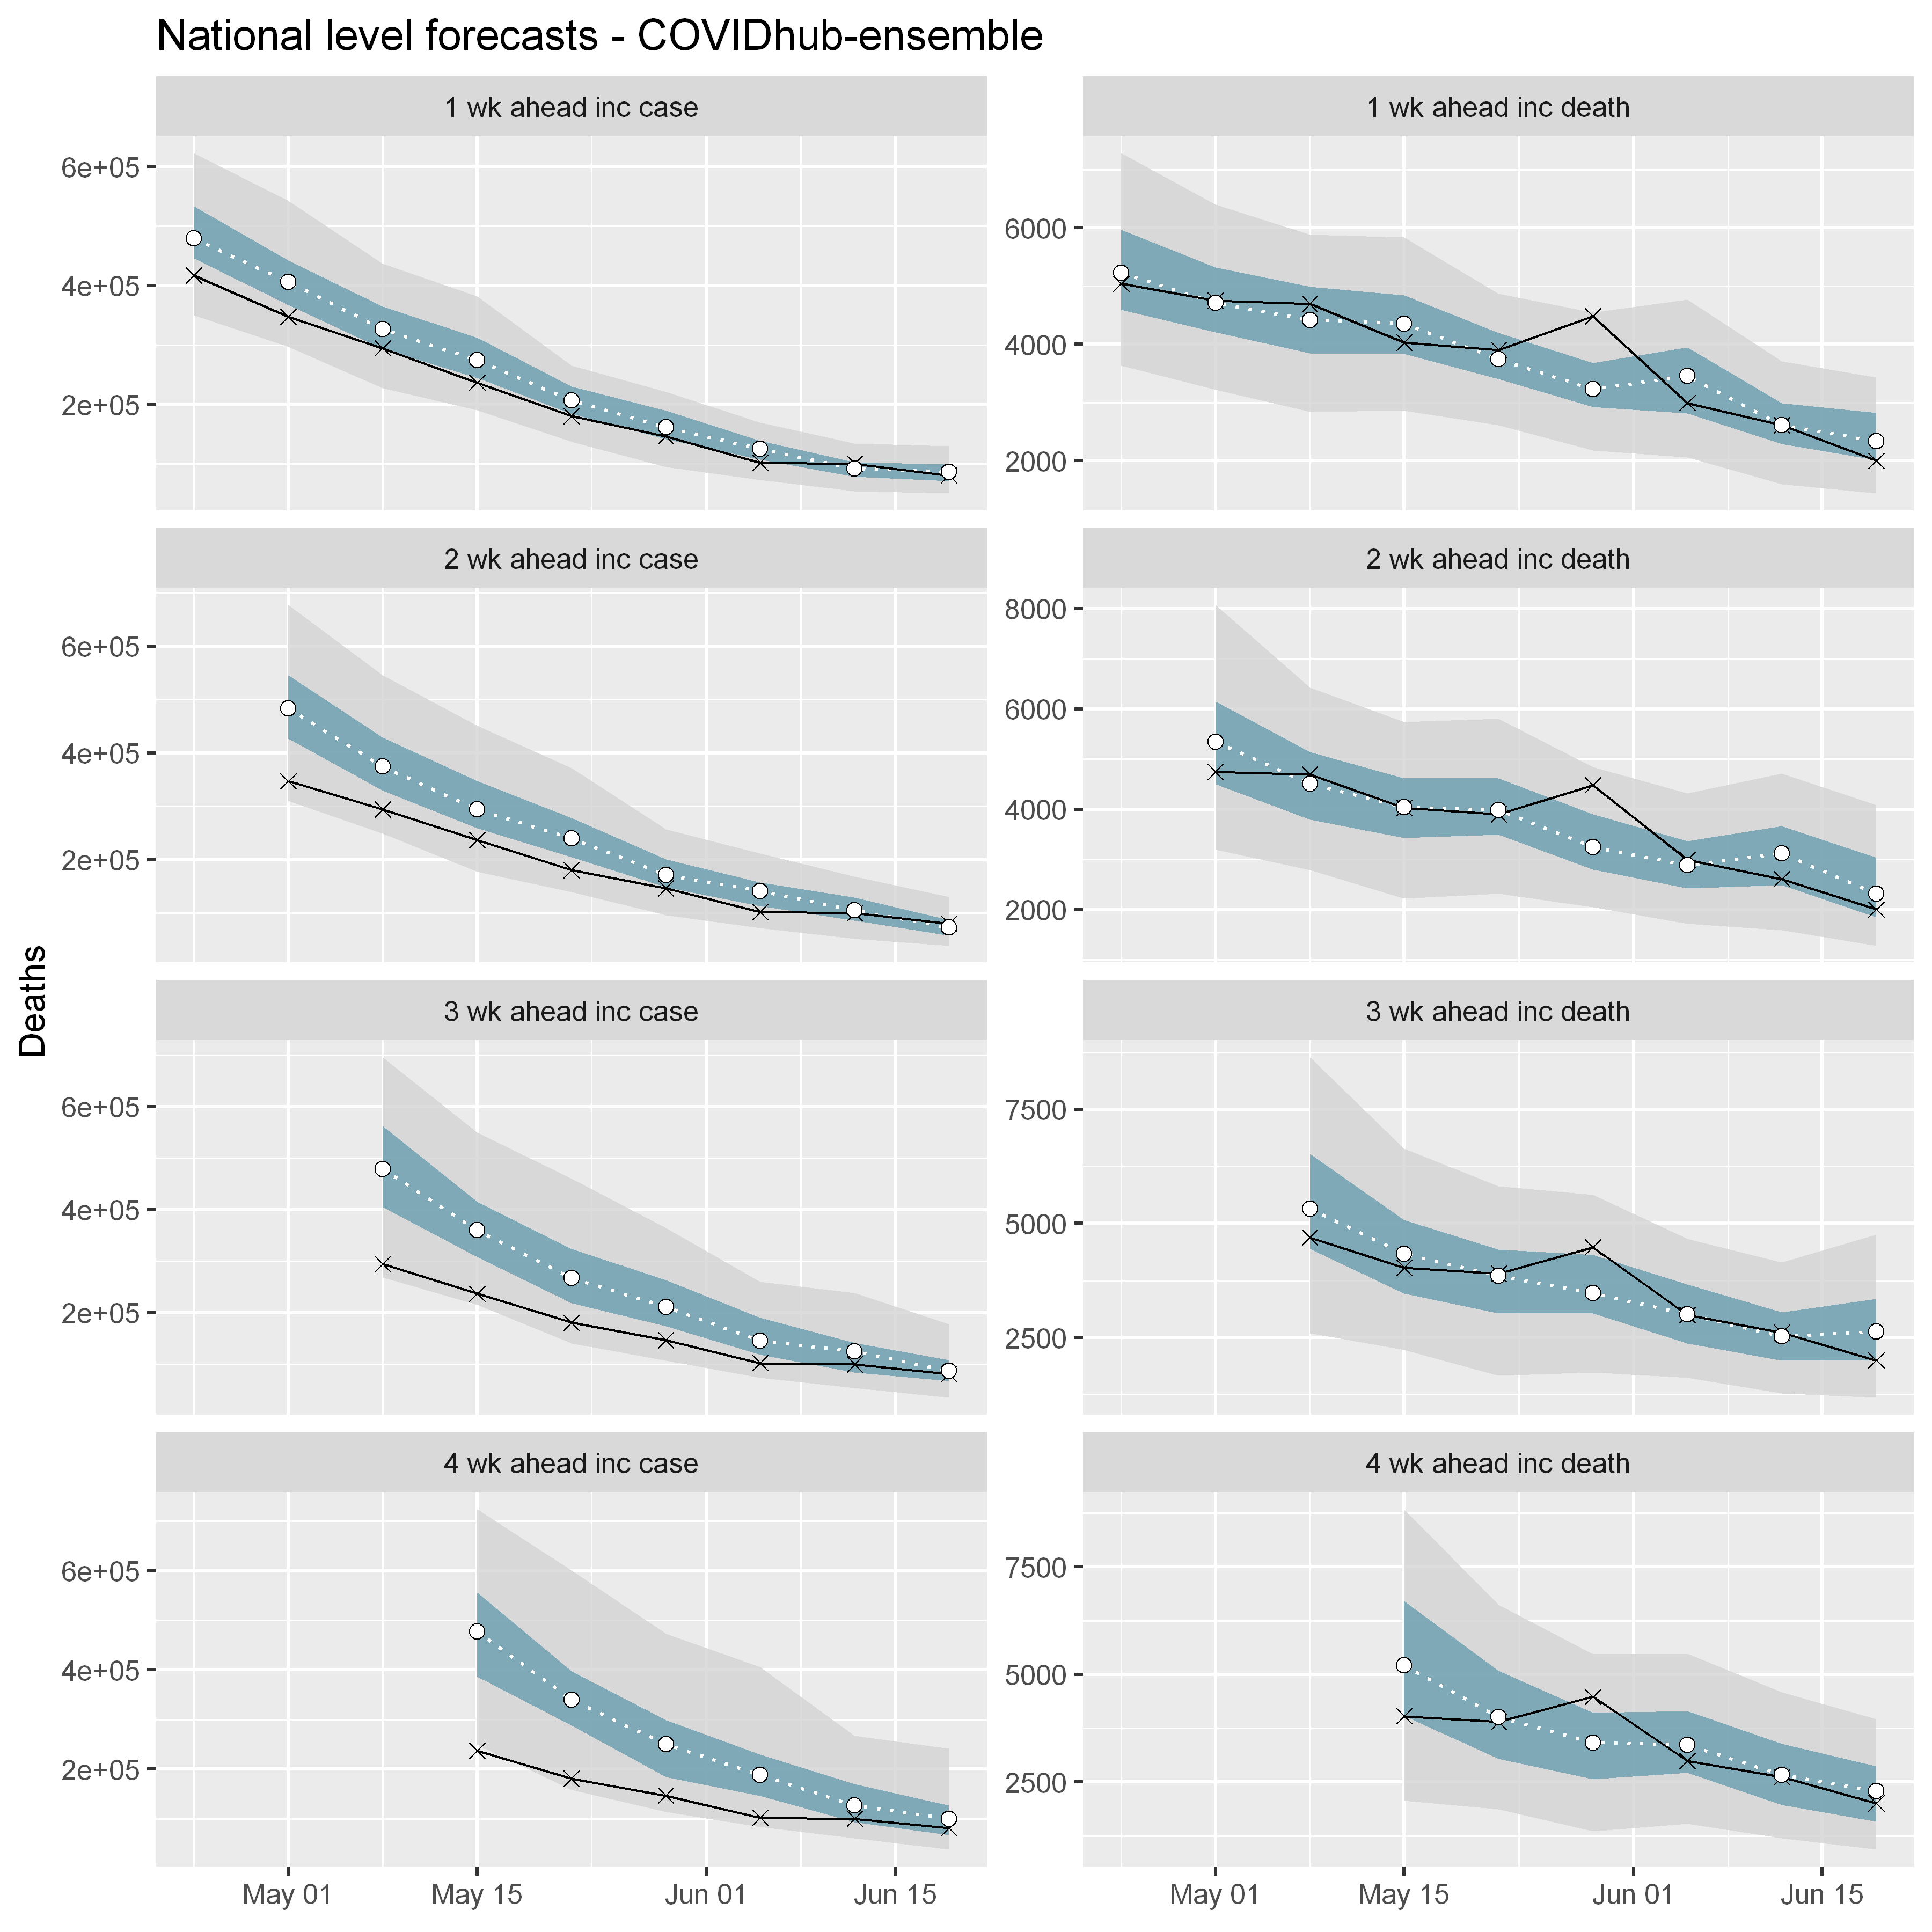

In [28]:
ggplot(df_ens, aes(x=target_end_date, y=truth)) +
  facet_wrap("target", scales="free_y", ncol=2) +
  geom_smooth(aes(y = value.0.5, ymin = value.0.025, ymax = value.0.975), 
              linetype=3, size=0.7, colour="white", fill=cols[2], alpha=0.8, stat = "identity") +
  geom_smooth(aes(y = value.0.5, ymin = value.0.25, ymax = value.0.75),
              linetype=3, size=0.7, colour="white", fill=cols[1], alpha=0.8, stat = "identity") +
  geom_line() +
  geom_point(pch = 4, size=3) +
  geom_point(aes(y = value.0.5), pch = 21, col = "black", bg = "white", size=3) +
  theme_bw() +
  labs(title="National level forecasts - COVIDhub-ensemble",
       x = NULL,
       y = "Deaths") +
  theme_grey(base_size=16) +
  theme(strip.text.y = element_text(size = 8))